In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

from sklearn import preprocessing

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

## Statistical Analysis helper functions

In [2]:
# Get Basic Column Statistics values - max, min, count, average, standard deviation, first, last

def get_col_count(df, col): return df[col].count()
def get_col_min(df, col):   return df[col].min()
def get_col_max(df, col):   return df[col].max()
def get_col_avg(df, col):   return df[col].mean()
def get_first(df):          return df.iloc[0]
def get_last(df):           return df.iloc[-1]
def get_col_std(df, col):   return df[col].std()

In [3]:
# Correlation matrix (only triangle)
def get_df_correlation(df, figure_size=(11, 9)):
    # Get correlation matrix
    corr = df.corr()

    # Mask for upper triangle
    triangle_mask = np.zeros_like(corr, dtype=np.bool)
    triangle_mask[np.triu_indices_from(triangle_mask)] = True
    
    # Size of plot
    plt.subplots(figsize=figure_size)

    # Generate a custom diverging colormap https://seaborn.pydata.org/tutorial/color_palettes.html
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=triangle_mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

## Generalized Plot-related Functions

In [4]:
# Bar plot for the chosen column of the provided dataframe
def bar_plot(df, col):
    feature_count = "{}_count".format(col)
    
    grouped_df = df.groupby([col])
    aggregation = grouped_df.agg({col: ['count']}).reset_index()
    aggregation.columns = [col, feature_count]
    sns.barplot(x = aggregation[col], y = aggregation[feature_count], palette="magma")
    plt.show()
    
# Scatter plot for 2 chosen columns of the provided dataframe
def scatter_plot_two_cols(df, x_col, y_col, figure_size=(12, 9)):
    
    # Size of plot
    plt.subplots(figsize=figure_size)
    
    # Generate a custom diverging colormap https://seaborn.pydata.org/tutorial/color_palettes.html
    cmap = sns.diverging_palette(220, 20, as_cmap=True) 

    sns.scatterplot(data=df, x=x_col, y=y_col, hue='status',palette=cmap, sizes=(47,47))
    plt.show()

# Bubble plot for 3 chosen columns of the provided dataframe
def bubble_plot_three_cols(df, x_col, y_col, hue_size_col):
    
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_size_col, size=hue_size_col, palette=cmap, sizes=(50, 300))

    plt.show()
    
# Histogram for Features of dataframe
def get_features_histogram(df, figure_size=(20, 25)):

    fig = plt.figure(figsize=figure_size)
    loan = df[df.status==1]
    do_not_loan = df[df.status==-1]
    j = 0

    for i in range(len(df.columns)):
        plt.subplot(math.ceil(len(df.columns) / 3), 3, j+1)
        j += 1
        sns.distplot(loan.iloc[:, i], color='g', label = 'loan',
                    kde = False if len(loan.iloc[:, i].unique()) == 1 else True)
        sns.distplot(do_not_loan.iloc[:, i], color='r', label = 'no loan',
                    kde = False if len(do_not_loan.iloc[:, i].unique()) == 1 else True)
        plt.legend(loc='best')

    fig.suptitle('Feature Analysis')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

## Encoding/atributes' type-related helper functions

In [5]:
# Convert date (seen as type object) to datetime
def convert_date(df, column, format_='%y%m%d'):
    df_ = df.copy() # copy dataframe to avoid making changes to it inside the function
    df_[column] = pd.to_datetime(df_[column], format=format_)
    return df_

In [6]:
# Encode column of dataframe
def encode_column(df, column_to_encode):
    
    df_ = df.copy() # copy dataframe to avoid making changes to it inside the function
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df_[column_to_encode].unique())
    df_[column_to_encode] = label_encoder.transform(df_[column_to_encode])
    
    return df_

## Missing Values

In [7]:
# Missing Values summary of provided dataset
def missing_values(dataset):
    display(dataset.isnull().mean())

In [8]:
# Missing Values Cleaning
def missing_values_cleaning(df):
    
    # Drop columns with missing value percentage > 0.7
    df = df[ df.columns[ df.isnull().mean() < 0.7 ] ]

    # Drop rows    with missing value percentage > 0.7
    df = df.loc[ df.isnull().mean(axis = 1) < 0.7 ]
    
    return df

In [9]:
# Missing Values Treatment: for numerical columns, replace with custom value or median 
def clean_numerical_missing_values(dataset, replacer=None):

    dataset = dataset.fillna(replacer if replacer is not None else dataset.median())
    return dataset

# Missing Values Treatment: for categorical columns, replace with custom value or max value (that isn't null)
def clean_categorical_missing_values(dataset, col, replacer=None):

    dataset[col].fillna(replacer if replacer is not None else dataset[col].value_counts().idxmax(), inplace=True)
    
    return dataset

# Feature Selection Algorithms

## Filter Method - Correlation Threshold

In [10]:
filter_features = []

# Apply to train (only!)
def select_features_filtering(original_df):

    original_corr = original_df.corr()
    
    # gets only last row (only one that really matters here)
    # and drops status col (not useful for correlation with itself)
    status_corr = original_corr.tail(1).drop(['status'], axis = 1)

    print('Correlations with label:')
    display(status_corr)
    
    # ':' means it applies to every row
    status_corr = status_corr.loc[:, ( abs(status_corr) > 0.15 ).any()]

    # print('Features that made it:')
    # display(status_corr)

    for col in status_corr: filter_features.append(col)

## Wrapper Method - Logistic Regression
#### Parameters: max_iter=1000, k_features='best', forward=True, floating=False,verbose=2, scoring='roc_auc', n_jobs=-1, cv=0

In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression as LGR

In [12]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

wrapper_features = []

def analyse_sfs(sfs1):
    display(sfs1.subsets_)
    print('-----')
    display(sfs1.get_metric_dict())
    print('-----')
    
    fig1 = plot_sfs(sfs1.get_metric_dict(confidence_interval=0.95), kind='std_err')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()
    
    print("-------------------------")

    display(sfs1.k_feature_names_, sfs1.k_feature_idx_)

    print("-------------------------")
    
    dfy_ = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
    dfy_[["feature_idx", "avg_score"]]
    wrapper_features = dfy_[["feature_idx"]]

In [13]:
def select_features_wrapper(origin_df):
    
    features = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number).columns
    
    X = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number)
    y = origin_df['status']
    
    print("X columns:")
    print(X.dtypes)
    print("Y:")
    print(y)
    print()
    
    # Only run in train
    sfs1 = SFS(LGR(max_iter=1000),
               k_features='best',
               forward=True,
               floating=False,
               verbose=2,
               scoring='roc_auc', #roc_auc #accuracy
               n_jobs=-1,
               cv=0)
    
    sfs1 = sfs1.fit(X, y, custom_feature_names=features)
    
    analyse_sfs(sfs1)

# Feature Engineering

## Load data

In [14]:
# Loading the tables both used for train and test
account_df = pd.read_csv('./raw/account.csv', delimiter=";")
disp_df = pd.read_csv('./raw/disp.csv', delimiter=';')
client_df = pd.read_csv('./raw/client.csv', delimiter=';')
district_df = pd.read_csv('./raw/district.csv', delimiter=';')

# Loading the train tables
loan_df = pd.read_csv('./raw/loan_dev.csv', delimiter=';')
card_df = pd.read_csv('./raw/card_dev.csv', delimiter=';')
trans_df = pd.read_csv('./raw/trans_dev.csv', delimiter=';')

# Loading the test tables
loan_test_df = pd.read_csv('./raw/loan_comp.csv', delimiter=';')
card_test_df = pd.concat([pd.read_csv('./raw/card_comp.csv', delimiter=';'), card_df])
trans_test_df = pd.concat([pd.read_csv('./raw/trans_comp.csv', delimiter=';'), trans_df])

print('\n\n\t ACCOUNT TABLE')
display(account_df.head())

print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())

print('\n\n\t CLIENT TABLE')
display(client_df.head())

print('\n\n\tDISTRICT TABLE')
display(district_df.head())

print('\n\n\t LOAN TABLE')
display(loan_df.head())

print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())

print('\n\n\tTRANSACTIONS TABLE')
display(trans_df.head())



	 ACCOUNT TABLE


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102




	 DISPOSITION TABLE


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT




	 CLIENT TABLE


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5




	DISTRICT TABLE


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040




	 LOAN TABLE


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1




	 CREDIT CARD TABLE


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215




	TRANSACTIONS TABLE


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


# Individual preprocessing of tables

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


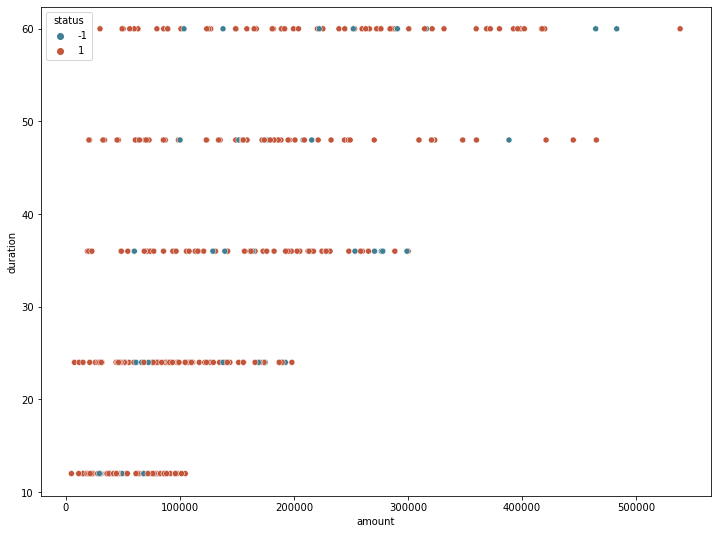

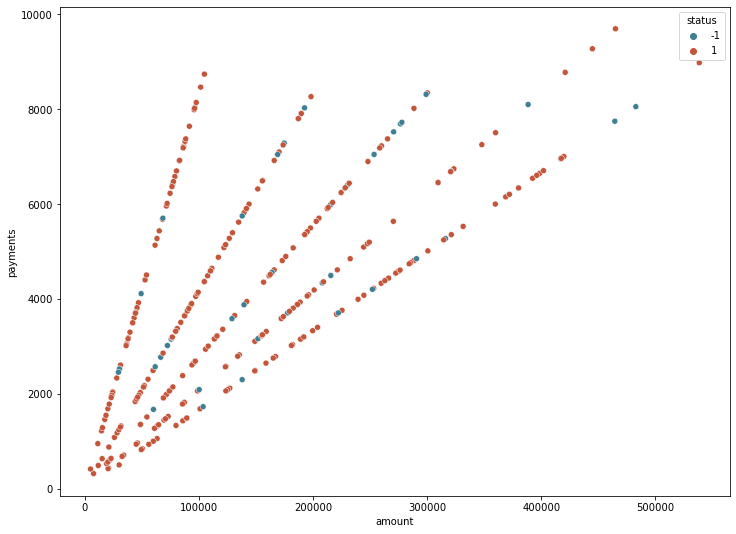

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


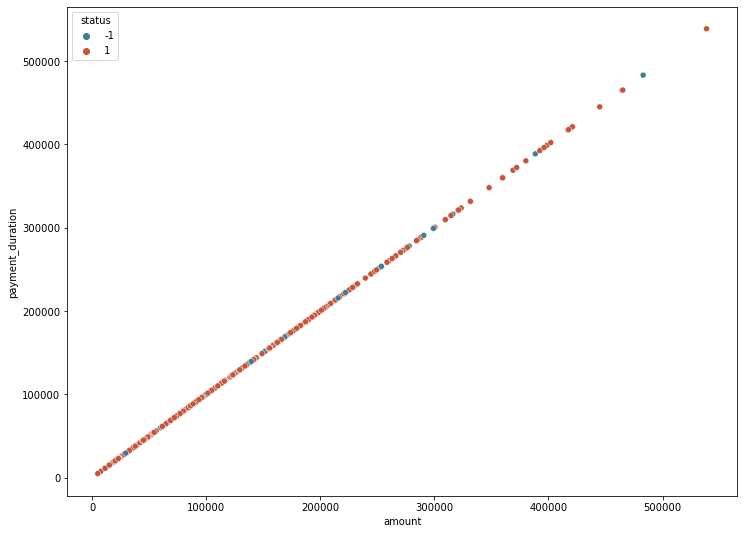

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033,-1
1,5316,1801,1993-07-11,165960,36,4610,1
2,6863,9188,1993-07-28,127080,60,2118,1
3,5325,1843,1993-08-03,105804,36,2939,1
4,7240,11013,1993-09-06,274740,60,4579,1
...,...,...,...,...,...,...,...
323,6818,9030,1996-12-12,155616,48,3242,1
324,5625,3189,1996-12-15,222180,60,3703,-1
325,6805,8972,1996-12-21,45024,48,938,1
326,7233,10963,1996-12-25,115812,36,3217,1


In [15]:
def process_loans(loans_df):

    # print('Raw loans representation')
    # display(loans_df)
    # print('Raw loans correlations')
    # get_df_correlation(loans_df)
        
    processed_df = convert_date(loans_df, 'date')
    
    print('No past history regarding loans.\nThere is an obvious and expected correlation between the duration, amount and payments columns.')
    scatter_plot_two_cols(processed_df, 'amount', 'duration')
    scatter_plot_two_cols(processed_df, 'amount', 'payments')
    print('As expected, the larger the amount, the larger is the monthly payment or the duration.')

    print('Does the bank charge any interest rate?')
    processed_df['payment_duration'] = processed_df['duration'] * processed_df['payments']
    scatter_plot_two_cols(processed_df, 'amount', 'payment_duration')

    processed_df = processed_df.drop(['payment_duration'], axis=1)

    print('amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan')
        
    return processed_df

process_loans(loan_df)

In [16]:
def process_account(accounts_df):

    # print('Accounts:')
    # display(accounts_df)
    # get_df_correlation(accounts_df)
        
    processed_account = convert_date(account_df, 'date')
    
    # Encode categorical column
    df = encode_column(processed_account, 'frequency')
    
    # display(df)
    # print('Features correlation:')
    # get_df_correlation(df)

    return df

processed_account = process_account(account_df)

Transformed the categorical type column into numerical respective columns


,disp_id,client_id,account_id,type_O,type_U
0,1,1,1,1,0
1,2,2,2,1,0
2,3,3,2,0,1
3,4,4,3,1,0
4,5,5,3,0,1
...,...,...,...,...,...
5364,13647,13955,11349,1,0
5365,13648,13956,11349,0,1
5366,13660,13968,11359,1,0
5367,13663,13971,11362,1,0


2 categories are dependent. Therefore, remove one - removing redundancy


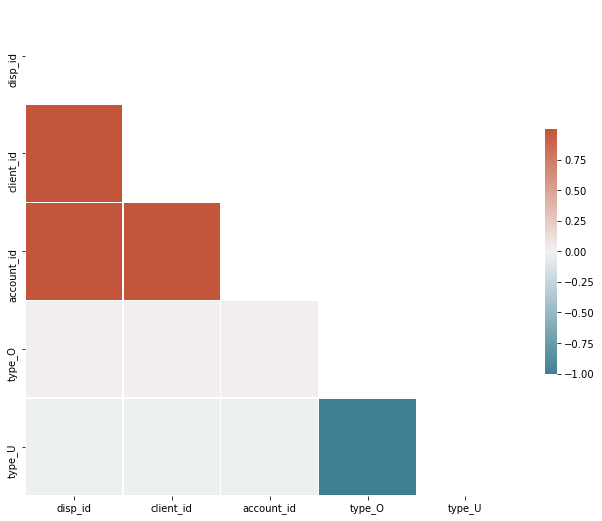

In [17]:
def process_dispostition(disp_df):
    
    # display(disp_df)
    # get_df_correlation(disp_df)
        
    processed_disp = disp_df.copy()
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"] == "OWNER",    "type"] = "O"
    processed_disp.loc[processed_disp["type"] == "DISPONENT","type"] = "U"
    
    # Transform numerical into categorical
    df = pd.get_dummies(processed_disp)
    
    print('Transformed the categorical type column into numerical respective columns')
    display(df)
    print('2 categories are dependent. Therefore, remove one - removing redundancy')
    get_df_correlation(df)
        
    return df

processed_disp = process_dispostition(disp_df)

In [18]:
def process_card(card_df):

    # display(card_df)
    # get_df_correlation(card_df)

    processed_card = convert_date(card_df, 'issued')
    

    # print('The distribution of type of cards per client:')
    # bar_plot(processed_card, 'type')

    df = encode_column(processed_card, 'type')
    df = df.drop(['card_id'], axis=1)
    
    # display(df)
        
    # Cannot process further as needs merging with other columns
    return df

processed_card = process_card(card_df)

In [19]:
def process_client(client_df):
    

    # display(client_df)
    # get_df_correlation(client_df)
        
    processed_df = client_df.copy()
        
    # Getting year, day, and month+50 if women
    processed_df['year'] = 1900 + (processed_df['birth_number'] // 10000)
    processed_df['month_gender'] = (processed_df['birth_number'] % 10000) // 100
    processed_df['day'] = processed_df['birth_number'] % 100

    # Extracting gender and month
    processed_df['gender'] = np.where(processed_df['month_gender']>=50, 1, 0)
    processed_df['month'] = np.where(processed_df['month_gender']>=50, processed_df['month_gender']-50, processed_df['month_gender'])

    # Composing data
    processed_df['birth_date'] = processed_df['year'] * 10000 + processed_df['month'] * 100 + processed_df['day']
    df = convert_date(processed_df, 'birth_date', '%Y%m%d')
    
    # Drop now useless columns
    df = df.drop(['birth_number', 'year', 'month_gender', 'month', 'day'], axis=1)
    
    print('1 = female\t\t 0 = male')
    display(df)
    # get_df_correlation(df)
    
    return df

processed_client = process_client(client_df)

1 = female		 0 = male


,client_id,district_id,gender,birth_date
0,1,18,1,1970-12-13
1,2,1,0,1945-02-04
2,3,1,1,1940-10-09
3,4,5,0,1956-12-01
4,5,5,1,1960-07-03
...,...,...,...,...
5364,13955,1,1,1945-10-30
5365,13956,1,0,1943-04-06
5366,13968,61,0,1968-04-13
5367,13971,67,1,1962-10-19


Current processed_df


,trans_id,account_id,date,type,operation,amount,balance,k_symbol
395175,175,1,1996-12-31,withdrawal,withd_cash,-14.6,12659.9,payment for statement
396435,3530458,1,1996-12-31,credit,interest,59.2,12674.5,interest credited
388524,99,1,1996-12-18,withdrawal,withd_cash,-180.0,12615.3,
386550,25,1,1996-12-13,credit,col_another_bank,3679.0,16495.3,
386552,219,1,1996-12-13,withdrawal,withd_cash,-3700.0,12795.3,
...,...,...,...,...,...,...,...,...
202560,3459062,11382,1995-09-30,credit,interest,40.4,24272.4,interest credited
204824,3530267,11382,1995-09-30,credit,interest,37.0,24309.4,interest credited
200744,3431245,11382,1995-09-19,withdrawal,withd_cash,-6800.0,24232.0,
198263,3431070,11382,1995-09-10,credit,col_another_bank,30832.0,31032.0,


At end of process_transactions


,account_id,balance_mean,balance_max,balance_min,balance_std,last_balance,first_balance,last_trans_date,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,household,pension,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash,credit_cash_mean,credit_cash_sum,credit_cash_max,credit_cash_std,credit_cash_min,col_another_bank,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest,interest_mean,interest_sum,interest_max,interest_std,interest_min,withd_cash,withd_cash_mean,withd_cash_sum,withd_cash_max,withd_cash_std,withd_cash_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_std,rem_another_bank_min,credit_card_withd,credit_card_withd_mean,credit_card_withd_sum,credit_card_withd_max,credit_card_withd_std,credit_card_withd_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,last_first_balance_ratio,last_max_balance_ratio,ratio_credit_cash,ratio_col_another_bank,ratio_withd_cash,ratio_rem_another_bank,ratio_credit_card_withd,ratio_interest
0,1,17558.700000,30414.8,1000.0,4168.729384,12659.9,1000.0,1996-12-31,-14.6,1.0,1992.602000,50,12600.0,19.2,2298.080022,-1380.479365,63.0,-14.6,-7500.0,1463.225675,-2452.0,0.0,857.101695,50569.0,59,3136.099558,-14.6,-248.2,17.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,8,2600.000000,20800.0,12600.0,4120.679556,100.0,21.0,3679.000000,77259.0,3679.0,0.000000,3679.0,21.0,74.814286,1571.1,108.9,18.910798,19.2,47.0,-1015.706383,-47738.2,-14.6,1533.109438,-7500.0,16.0,-2452.000000,-39232.0,-2452.0,0.000000,-2452.0,0.0,0.0,0.0,0.0,0.000000,0.0,612.122635,113.0,0.442478,0.557522,29414.8,12.659900,0.416241,0.070796,0.185841,0.415929,0.141593,0.000000,0.185841
1,2,32590.624074,67529.6,1100.0,12061.705682,27840.6,1100.0,1993-12-31,-14.6,1.0,10394.786364,22,30354.0,13.5,11457.269613,-6276.393750,32.0,-14.6,-22400.0,6011.475327,-7266.0,0.0,1908.151515,62969.0,33,14927.239619,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2,2400.000000,4800.0,3700.0,1838.477631,1100.0,10.0,22259.600000,222596.0,30354.0,4266.123382,20236.0,10.0,128.930000,1289.3,203.0,49.413607,13.5,27.0,-6093.133333,-164514.6,-14.6,6547.076631,-22400.0,5.0,-7266.000000,-36330.0,-7266.0,0.000000,-7266.0,0.0,0.0,0.0,0.0,0.000000,0.0,4118.392614,54.0,0.407407,0.592593,66429.6,25.309636,0.412273,0.037037,0.185185,0.500000,0.092593,0.000000,0.185185
2,4,23648.623077,30623.5,800.0,5779.862046,24943.0,800.0,1996-12-31,-14.6,1.0,3348.264706,17,5553.0,66.6,2721.128176,-1453.527273,22.0,-14.6,-4100.0,1147.934693,-2078.0,5553.0,-1725.000000,-20700.0,12,1261.094402,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,800.000000,800.0,800.0,0.000000,800.0,10.0,5553.000000,55530.0,5553.0,0.000000,5553.0,6.0,98.416667,590.5,110.0,16.204866,66.6,11.0,-1261.600000,-13877.6,-14.6,1585.793139,-4100.0,11.0,-1645.454545,-18100.0,-1285.0,414.130744,-2078.0,0.0,0.0,0.0,0.0,0.000000,0.0,1894.737433,39.0,0.435897,0.564103,29823.5,31.178750,0.814505,0.025641,0.256410,0.282051,0.282051,0.000000,0.153846
3,6,30313.279839,40391.5,900.0,5582.676041,33509.2,900.0,1996-12-31,-14.6,1.0,3603.666667,51,6669.0,70.3,3285.410780,-2058.600000,73.0,-14.6,-11600.0,2064.857715,-3954.0,6669.0,-2075.000000,-58100.0,28,2252.625629,-14.6,-335.8,23.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,900.000000,900.0,900.0,0.000000,900.0,27.0,6669.000000,180063.0,6669.0,0.000000,6669.0,23.0,122.782609,2824.0,146.3,17.056261,70.3,50.0,-1186.716000,-59335.8,-14.6,1950.114384,-11600.0,23.0,-3954.000000,-90942.0,-3954.0,0.000000,-3954.0,0.0,0.0,0.0,0.0,0.000000,0.0,1545.066667,124.0,0.411290,0.588710,39491.5,37.232444,0.829610,0.008065,0.217742,0.403226,0.185484

Corr matrix


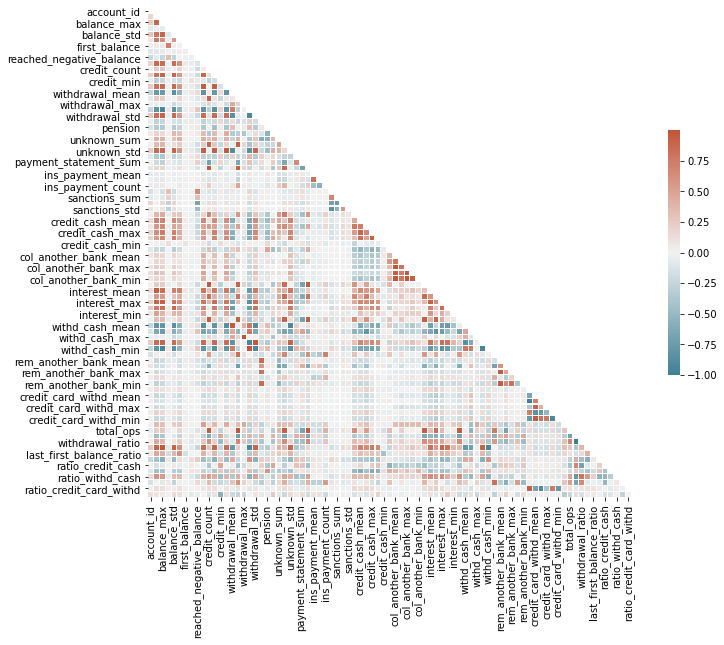

In [20]:
def process_transactions(transactions_df):

    # display(transactions_df)
    # get_df_correlation(transactions_df)
    # missing_values(transactions_df)
        
    # Removing the null columns & processing data
    processed_df = missing_values_cleaning(transactions_df)
    processed_df = convert_date(processed_df, 'date')
    
    # Filling null columns with too much nulls
    processed_df = clean_categorical_missing_values(processed_df, 'k_symbol', ' ')
    
    # print('Type of trans operations (unique):')
    # display(processed_df['operation'].unique())
    # print('Type of trans k_symbol:')
    # display(processed_df['k_symbol'].unique())
    
    processed_df.loc[processed_df["type"] == "withdrawal in cash", "type"] = "withdrawal" # 'withdrawal in cash' -> 'withdrawal'

    # Renaming of operations
    processed_df.loc[ processed_df["operation"] == "credit in cash",               "operation"] = "credit_cash"
    processed_df.loc[ processed_df["operation"] == "collection from another bank", "operation"] = "col_another_bank"
    processed_df.loc[ processed_df["operation"] == "withdrawal in cash",           "operation"] = "withd_cash"
    processed_df.loc[ processed_df["operation"] == "remittance to another bank",   "operation"] = "rem_another_bank"
    processed_df.loc[ processed_df["operation"] == "credit card withdrawal",       "operation"] = "credit_card_withd"
    
    processed_df = clean_categorical_missing_values(processed_df, 'operation', 'interest') # Interest credited
    
    # Making withdrawals amount negatives
    processed_df.loc[processed_df["type"]=="withdrawal", "amount"] *=-1 
    
    print('Current processed_df')
    display(processed_df.sort_values(by=['account_id', 'date'], ascending=[True, False]))
    # display(processed_df['operation'].unique())
    
    # Aggregatting transaction balances
    agg_ballance = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                               .groupby(['account_id'])\
                               .agg({
                                    'balance': ['mean', 'max', 'min', 'std', get_first, get_last],
                                    'date': get_first,
                                    'amount': get_first
                               }).reset_index()
    agg_ballance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std',
                            'last_balance', 'first_balance', 'last_trans_date', 'last_trans']
    agg_ballance['reached_negative_balance'] = agg_ballance['balance_min']
    agg_ballance.loc[agg_ballance["balance_min"] >= 0, "reached_negative_balance"] = 1
    agg_ballance.loc[agg_ballance["balance_min"] < 0, "reached_negative_balance"] = -1

    # Agrregatting credits &. withdrawals
    agg_types = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                              .groupby(['account_id', 'type'])\
                              .agg({
                                  'amount': ['mean', 'count', 'max', 'min', 'std'],
                              })\
                              .reset_index()
    agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count',
                           'type_max', 'type_min', 'type_std']

    agg_credits = agg_types[agg_types['type'] == 'credit']
    agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count',
                           'credit_max', 'credit_min', 'credit_std']
    agg_credits.drop(['type'], axis=1)
    
    agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count',
                           'withdrawal_max', 'withdrawal_min', 'withdrawal_std']
    agg_withdrawals.drop(['type'], axis=1)
    
    # Aggregatting k_symbols
    agg_k_symbol = processed_df.groupby(['account_id', 'k_symbol'])\
                           .agg({
                               'amount': ['mean', 'sum', 'count', 'std']
                           })\
                           .reset_index()
    agg_k_symbol.columns = ['account_id', 'k_symbol', 'amount_mean',
                            'amount_sum', 'amount_count', 'amount_std']

    
    # households - only mean is interesting
    households = agg_k_symbol[agg_k_symbol['k_symbol'] == 'household']
    households.columns = ['account_id', 'k_symbol', 'household', '_1', '_2', '_3']
    households = households.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # pensions - only mean is interesting
    pensions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'old-age pension']
    pensions.columns = ['account_id', 'k_symbol', 'pension', '_1', '_2', '_3']
    pensions = pensions.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # unknown stats
    unknown = agg_k_symbol[agg_k_symbol['k_symbol'] == ' ']
    unknown.columns = ['account_id', 'k_symbol', 'unknown_mean', 'unknown_sum', 'unknown_count', 'unknown_std']
    unknown = unknown.drop(['k_symbol'], axis=1)

    # payments for statement
    payment_st = agg_k_symbol[agg_k_symbol['k_symbol'] == 'payment for statement']
    payment_st.columns = ['account_id', 'k_symbol', 'payment_statement_mean', 'payment_statement_sum', 'payment_statement_count', '_2']
    payment_st = payment_st.drop(['k_symbol', '_2'], axis=1)
    
    # insurance payment
    ins_payment = agg_k_symbol[agg_k_symbol['k_symbol'] == 'insurrance payment']
    ins_payment.columns = ['account_id', 'k_symbol', 'ins_payment_mean', 'ins_payment_sum', 'ins_payment_count', '_2']
    ins_payment = ins_payment.drop(['k_symbol', '_2'], axis=1)
    
    # saction payment
    sanctions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'sanction interest if negative balance']
    sanctions.columns = ['account_id', 'k_symbol', 'sanctions_mean', 'sanctions_sum', 'sanctions_count', 'sanctions_std']
    sanctions = sanctions.drop(['k_symbol'], axis=1)

    # Aggregatting all the 5 tables into one - agg_ballance, agg_credits, agg_withdrawals, households & pensions
    df = agg_ballance.merge(agg_credits, on='account_id', how='left')\
                     .merge(agg_withdrawals, on='account_id', how='left')\
                     .merge(households, on='account_id', how='left')\
                     .merge(pensions, on='account_id', how='left')\
                     .merge(unknown, on='account_id', how='left')\
                     .merge(payment_st, on='account_id', how='left')\
                     .merge(ins_payment, on='account_id', how='left')\
                     .merge(sanctions, on='account_id', how='left')

    
    # Cleaning nulls
    df = df.drop(['type_x', 'type_y'], axis=1)
    df = clean_numerical_missing_values(df, 0)

    
    # Cleaning nulls and performing aggreggation on table containing operations
    operations = processed_df.groupby(['account_id', 'operation'])\
                             .agg({
                                 'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],
                             })\
                             .reset_index()
    operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum',
                          'amount_max', 'amount_std', 'amount_min']
    
    # Getting credit_cash
    credit_cash = operations[operations['operation'] == 'credit_cash']
    credit_cash.columns = ['account_id', 'operation', 'credit_cash', 'credit_cash_mean', 'credit_cash_sum', 'credit_cash_max', 'credit_cash_std', 'credit_cash_min']
    credit_cash = credit_cash.drop(['operation'], axis=1)
    
    # col_another_bank
    cab = operations[operations['operation'] == 'col_another_bank']
    cab.columns = ['account_id', 'operation', 'col_another_bank', 'col_another_bank_mean', 'col_another_bank_sum', 'col_another_bank_max', 'col_another_bank_std', 'col_another_bank_min']
    cab =cab.drop(['operation'], axis=1)
    
    # Getting interest
    interest = operations[operations['operation'] == 'interest']
    interest.columns = ['account_id', 'operation', 'interest', 'interest_mean', 'interest_sum', 'interest_max', 'interest_std', 'interest_min']
    interest = interest.drop(['operation'], axis=1)
    
    # Getting withd_cash
    withd_cash = operations[operations['operation'] == 'withd_cash']
    withd_cash.columns = ['account_id', 'operation', 'withd_cash', 'withd_cash_mean', 'withd_cash_sum', 'withd_cash_max', 'withd_cash_std', 'withd_cash_min']
    withd_cash = withd_cash.drop(['operation'], axis=1)
    
    # Getting rem_another_bank
    rem_another_bank = operations[operations['operation'] == 'rem_another_bank']
    rem_another_bank.columns = ['account_id', 'operation', 'rem_another_bank', 'rem_another_bank_mean', 'rem_another_bank_sum', 'rem_another_bank_max', 'rem_another_bank_std', 'rem_another_bank_min']
    rem_another_bank = rem_another_bank.drop(['operation'], axis=1)
    
    # Getting credit_card_withd
    credit_card_withd = operations[operations['operation'] == 'credit_card_withd']
    credit_card_withd.columns = ['account_id', 'operation', 'credit_card_withd', 'credit_card_withd_mean', 'credit_card_withd_sum', 'credit_card_withd_max', 'credit_card_withd_std', 'credit_card_withd_min']
    credit_card_withd = credit_card_withd.drop(['operation'], axis=1)
    
    # Joining all the operations
    operations_df = credit_cash.merge(cab, on='account_id', how='left')\
                      .merge(interest, on='account_id', how='left')\
                      .merge(withd_cash, on='account_id', how='left')\
                      .merge(rem_another_bank, on='account_id', how='left')\
                      .merge(credit_card_withd, on='account_id', how='left')
    # Cleaning nulls
    operations_df = clean_numerical_missing_values(operations_df, 0)
    
    # display(operations_df)
        
    # Join operations with the numeric data
    df = df.merge(operations_df, on='account_id', how='left')
    
    df['mean_trans_profit'] = df['credit_mean'] + df['withdrawal_mean']
    df['total_ops'] = df['credit_cash'] + df['col_another_bank'] + df['withd_cash'] + df['rem_another_bank'] + df['credit_card_withd'] + df['interest']
    df['credit_ratio'] = df['credit_count'] / df['total_ops']
    df['withdrawal_ratio'] = df['withdrawal_count'] / df['total_ops']
    df['balance_range'] = df['balance_max'] - df['balance_min']
    df['last_first_balance_ratio'] = df['last_balance'] / df['first_balance']
    df['last_max_balance_ratio'] = df['last_balance'] / df['balance_max']

    # Operations' ratios
    df['ratio_credit_cash']  = df['credit_cash']  / df['total_ops']
    df['ratio_col_another_bank'] = df['col_another_bank'] / df['total_ops']
    df['ratio_withd_cash']  = df['withd_cash']  / df['total_ops']
    df['ratio_rem_another_bank'] = df['rem_another_bank'] / df['total_ops']
    df['ratio_credit_card_withd'] = df['credit_card_withd'] / df['total_ops']
    df['ratio_interest']  = df['interest']  / df['total_ops']

    print('At end of process_transactions')
    display(df)
    # missing_values(df)
    print('Corr matrix')
    get_df_correlation(df)
    
    return df

processed_trans = process_transactions(trans_df)

code                                                 0.0
name                                                 0.0
region                                               0.0
no. of inhabitants                                   0.0
no. of municipalities with inhabitants < 499         0.0
no. of municipalities with inhabitants 500-1999      0.0
no. of municipalities with inhabitants 2000-9999     0.0
no. of municipalities with inhabitants >10000        0.0
no. of cities                                        0.0
ratio of urban inhabitants                           0.0
average salary                                       0.0
unemploymant rate '95                                0.0
unemploymant rate '96                                0.0
no. of enterpreneurs per 1000 inhabitants            0.0
no. of commited crimes '95                           0.0
no. of commited crimes '96                           0.0
dtype: float64

District Features Financial Relation


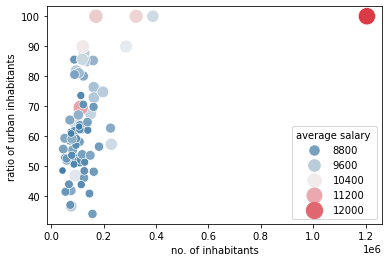

The final district plot, with additional features and having converted some features to ratios:


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,crime_delta,unemploymant_delta
0,1,17,0,1204953,0,0,0,1,1,1.000,12541,0.167,0.011146,0.14
1,2,0,1,88884,80,26,6,2,5,0.467,8507,0.132,0.005794,0.18
2,3,1,1,75232,55,26,4,1,5,0.417,8980,0.111,-0.000146,0.26
3,4,27,1,149893,63,29,6,2,6,0.674,9753,0.109,0.004323,0.41
4,5,29,1,95616,65,30,4,1,6,0.514,9307,0.118,0.004434,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,42,4,182027,17,49,12,2,7,0.564,8746,0.090,0.000429,0.41
73,74,43,4,323870,0,0,0,1,1,1.000,10673,0.100,-0.001343,0.69
74,75,53,4,138032,67,30,4,2,5,0.646,8819,0.099,0.003202,0.28
75,76,62,4,127369,31,32,13,2,7,0.512,8369,0.107,-0.007294,1.15


And the corresponding correlation matrix:


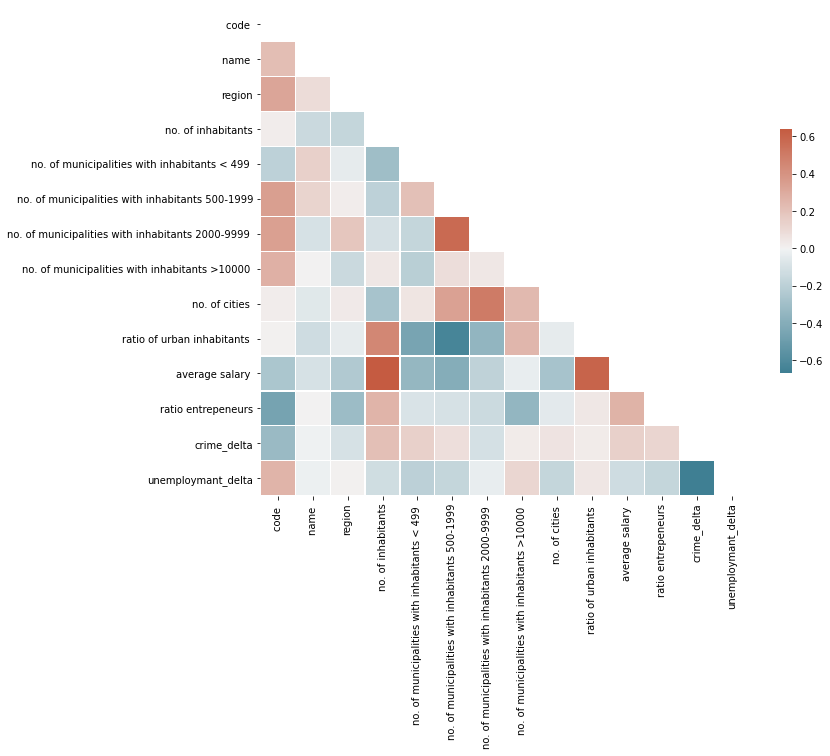

In [21]:
def process_district(district_df):
   
    missing_values(district_df)
        
    print('District Features Financial Relation')
    bubble_plot_three_cols(district_df, 'no. of inhabitants', 'ratio of urban inhabitants ', 'average salary ')
    
    # Encode categoricals
    df = encode_column(district_df, 'name ')
    df = encode_column(df, 'region')
    
    median_crimes_95 = pd.to_numeric(df[df['no. of commited crimes \'95 '] != '?']\
                                     ['no. of commited crimes \'95 ']).median()
    df.loc[df['no. of commited crimes \'95 ']=="?", 'no. of commited crimes \'95 '] = median_crimes_95

    median_unemploymant_95 = (df[df['unemploymant rate \'95 '] != '?']\
                              ['unemploymant rate \'95 ']).astype(float).median()
    df.loc[df['unemploymant rate \'95 ']=="?", 'unemploymant rate \'95 '] = median_unemploymant_95
    
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)

    df['ratio entrepeneurs'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    df['crime_delta'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) /\
                              df['no. of inhabitants']
    df['unemploymant_delta'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']
    
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 '], axis=1)
    

    print('The final district plot, with additional features and having converted some features to ratios:')
    display(df)
    print('And the corresponding correlation matrix:')
    get_df_correlation(df)

    return df.rename(columns={'code ': 'district_id'}).drop(['name '], axis=1)

processed_district = process_district(district_df)

# Pre process and merge tables

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


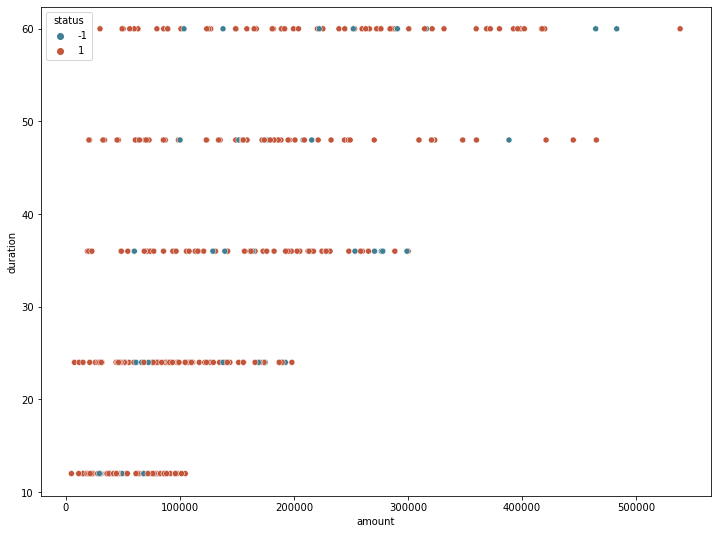

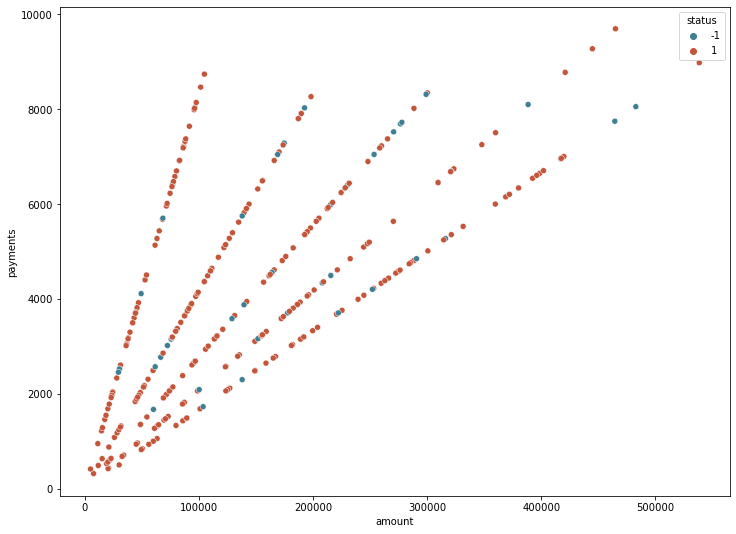

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


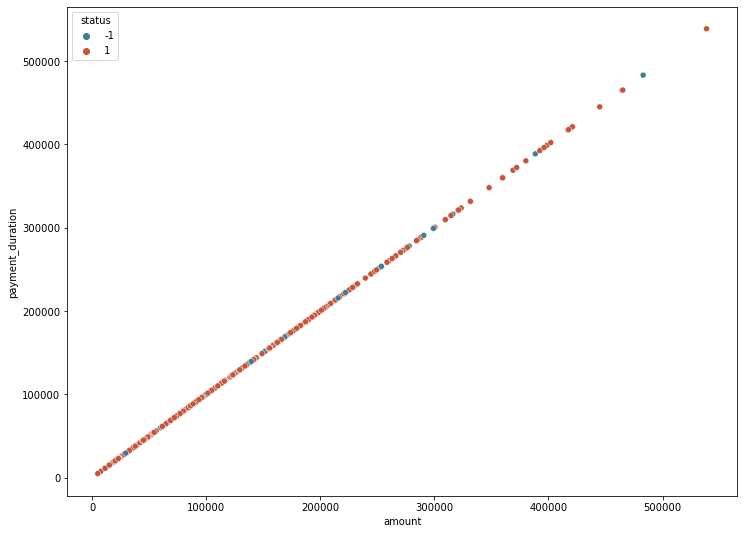

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan
Current processed_df


,trans_id,account_id,date,type,operation,amount,balance,k_symbol
395175,175,1,1996-12-31,withdrawal,withd_cash,-14.6,12659.9,payment for statement
396435,3530458,1,1996-12-31,credit,interest,59.2,12674.5,interest credited
388524,99,1,1996-12-18,withdrawal,withd_cash,-180.0,12615.3,
386550,25,1,1996-12-13,credit,col_another_bank,3679.0,16495.3,
386552,219,1,1996-12-13,withdrawal,withd_cash,-3700.0,12795.3,
...,...,...,...,...,...,...,...,...
202560,3459062,11382,1995-09-30,credit,interest,40.4,24272.4,interest credited
204824,3530267,11382,1995-09-30,credit,interest,37.0,24309.4,interest credited
200744,3431245,11382,1995-09-19,withdrawal,withd_cash,-6800.0,24232.0,
198263,3431070,11382,1995-09-10,credit,col_another_bank,30832.0,31032.0,


At end of process_transactions


,account_id,balance_mean,balance_max,balance_min,balance_std,last_balance,first_balance,last_trans_date,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,household,pension,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash,credit_cash_mean,credit_cash_sum,credit_cash_max,credit_cash_std,credit_cash_min,col_another_bank,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest,interest_mean,interest_sum,interest_max,interest_std,interest_min,withd_cash,withd_cash_mean,withd_cash_sum,withd_cash_max,withd_cash_std,withd_cash_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_std,rem_another_bank_min,credit_card_withd,credit_card_withd_mean,credit_card_withd_sum,credit_card_withd_max,credit_card_withd_std,credit_card_withd_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,last_first_balance_ratio,last_max_balance_ratio,ratio_credit_cash,ratio_col_another_bank,ratio_withd_cash,ratio_rem_another_bank,ratio_credit_card_withd,ratio_interest
0,1,17558.700000,30414.8,1000.0,4168.729384,12659.9,1000.0,1996-12-31,-14.6,1.0,1992.602000,50,12600.0,19.2,2298.080022,-1380.479365,63.0,-14.6,-7500.0,1463.225675,-2452.0,0.0,857.101695,50569.0,59,3136.099558,-14.6,-248.2,17.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,8,2600.000000,20800.0,12600.0,4120.679556,100.0,21.0,3679.000000,77259.0,3679.0,0.000000,3679.0,21.0,74.814286,1571.1,108.9,18.910798,19.2,47.0,-1015.706383,-47738.2,-14.6,1533.109438,-7500.0,16.0,-2452.000000,-39232.0,-2452.0,0.000000,-2452.0,0.0,0.0,0.0,0.0,0.000000,0.0,612.122635,113.0,0.442478,0.557522,29414.8,12.659900,0.416241,0.070796,0.185841,0.415929,0.141593,0.000000,0.185841
1,2,32590.624074,67529.6,1100.0,12061.705682,27840.6,1100.0,1993-12-31,-14.6,1.0,10394.786364,22,30354.0,13.5,11457.269613,-6276.393750,32.0,-14.6,-22400.0,6011.475327,-7266.0,0.0,1908.151515,62969.0,33,14927.239619,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2,2400.000000,4800.0,3700.0,1838.477631,1100.0,10.0,22259.600000,222596.0,30354.0,4266.123382,20236.0,10.0,128.930000,1289.3,203.0,49.413607,13.5,27.0,-6093.133333,-164514.6,-14.6,6547.076631,-22400.0,5.0,-7266.000000,-36330.0,-7266.0,0.000000,-7266.0,0.0,0.0,0.0,0.0,0.000000,0.0,4118.392614,54.0,0.407407,0.592593,66429.6,25.309636,0.412273,0.037037,0.185185,0.500000,0.092593,0.000000,0.185185
2,4,23648.623077,30623.5,800.0,5779.862046,24943.0,800.0,1996-12-31,-14.6,1.0,3348.264706,17,5553.0,66.6,2721.128176,-1453.527273,22.0,-14.6,-4100.0,1147.934693,-2078.0,5553.0,-1725.000000,-20700.0,12,1261.094402,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,800.000000,800.0,800.0,0.000000,800.0,10.0,5553.000000,55530.0,5553.0,0.000000,5553.0,6.0,98.416667,590.5,110.0,16.204866,66.6,11.0,-1261.600000,-13877.6,-14.6,1585.793139,-4100.0,11.0,-1645.454545,-18100.0,-1285.0,414.130744,-2078.0,0.0,0.0,0.0,0.0,0.000000,0.0,1894.737433,39.0,0.435897,0.564103,29823.5,31.178750,0.814505,0.025641,0.256410,0.282051,0.282051,0.000000,0.153846
3,6,30313.279839,40391.5,900.0,5582.676041,33509.2,900.0,1996-12-31,-14.6,1.0,3603.666667,51,6669.0,70.3,3285.410780,-2058.600000,73.0,-14.6,-11600.0,2064.857715,-3954.0,6669.0,-2075.000000,-58100.0,28,2252.625629,-14.6,-335.8,23.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,900.000000,900.0,900.0,0.000000,900.0,27.0,6669.000000,180063.0,6669.0,0.000000,6669.0,23.0,122.782609,2824.0,146.3,17.056261,70.3,50.0,-1186.716000,-59335.8,-14.6,1950.114384,-11600.0,23.0,-3954.000000,-90942.0,-3954.0,0.000000,-3954.0,0.0,0.0,0.0,0.0,0.000000,0.0,1545.066667,124.0,0.411290,0.588710,39491.5,37.232444,0.829610,0.008065,0.217742,0.403226,0.185484

Corr matrix


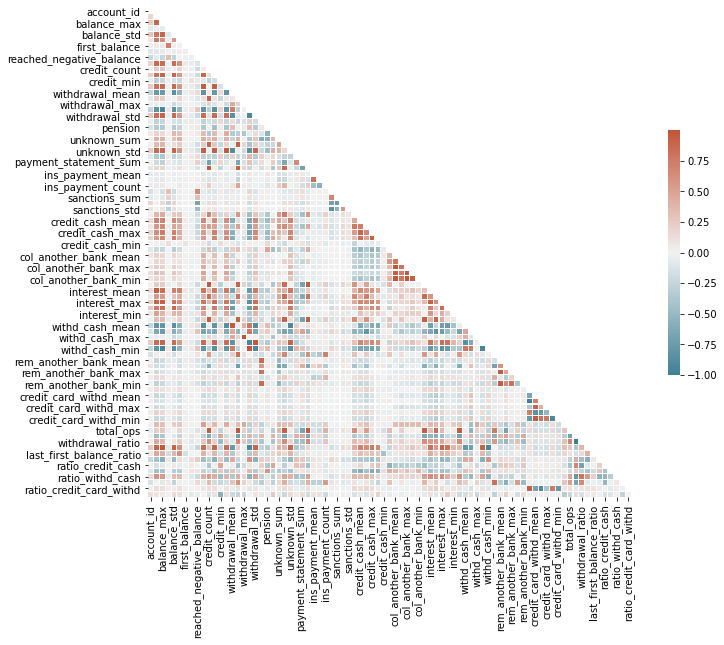

Transformed the categorical type column into numerical respective columns


,disp_id,client_id,account_id,type_O,type_U
0,1,1,1,1,0
1,2,2,2,1,0
2,3,3,2,0,1
3,4,4,3,1,0
4,5,5,3,0,1
...,...,...,...,...,...
5364,13647,13955,11349,1,0
5365,13648,13956,11349,0,1
5366,13660,13968,11359,1,0
5367,13663,13971,11362,1,0


2 categories are dependent. Therefore, remove one - removing redundancy


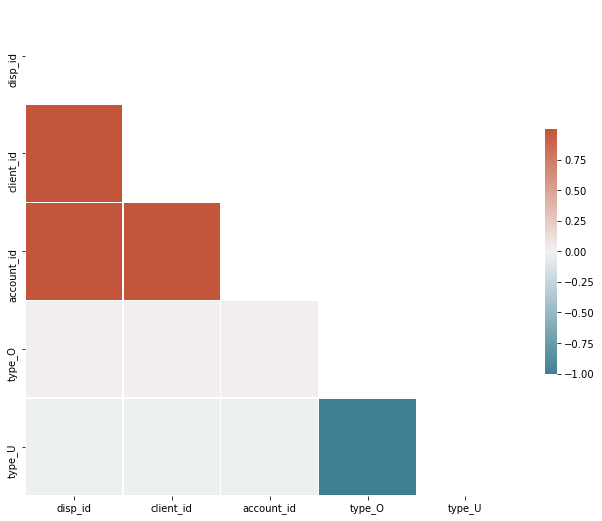

1 = female		 0 = male


,client_id,district_id,gender,birth_date
0,1,18,1,1970-12-13
1,2,1,0,1945-02-04
2,3,1,1,1940-10-09
3,4,5,0,1956-12-01
4,5,5,1,1960-07-03
...,...,...,...,...
5364,13955,1,1,1945-10-30
5365,13956,1,0,1943-04-06
5366,13968,61,0,1968-04-13
5367,13971,67,1,1962-10-19


code                                                 0.0
name                                                 0.0
region                                               0.0
no. of inhabitants                                   0.0
no. of municipalities with inhabitants < 499         0.0
no. of municipalities with inhabitants 500-1999      0.0
no. of municipalities with inhabitants 2000-9999     0.0
no. of municipalities with inhabitants >10000        0.0
no. of cities                                        0.0
ratio of urban inhabitants                           0.0
average salary                                       0.0
unemploymant rate '95                                0.0
unemploymant rate '96                                0.0
no. of enterpreneurs per 1000 inhabitants            0.0
no. of commited crimes '95                           0.0
no. of commited crimes '96                           0.0
dtype: float64

District Features Financial Relation


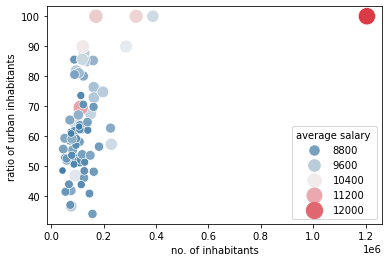

The final district plot, with additional features and having converted some features to ratios:


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,crime_delta,unemploymant_delta
0,1,17,0,1204953,0,0,0,1,1,1.000,12541,0.167,0.011146,0.14
1,2,0,1,88884,80,26,6,2,5,0.467,8507,0.132,0.005794,0.18
2,3,1,1,75232,55,26,4,1,5,0.417,8980,0.111,-0.000146,0.26
3,4,27,1,149893,63,29,6,2,6,0.674,9753,0.109,0.004323,0.41
4,5,29,1,95616,65,30,4,1,6,0.514,9307,0.118,0.004434,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,42,4,182027,17,49,12,2,7,0.564,8746,0.090,0.000429,0.41
73,74,43,4,323870,0,0,0,1,1,1.000,10673,0.100,-0.001343,0.69
74,75,53,4,138032,67,30,4,2,5,0.646,8819,0.099,0.003202,0.28
75,76,62,4,127369,31,32,13,2,7,0.512,8369,0.107,-0.007294,1.15


And the corresponding correlation matrix:


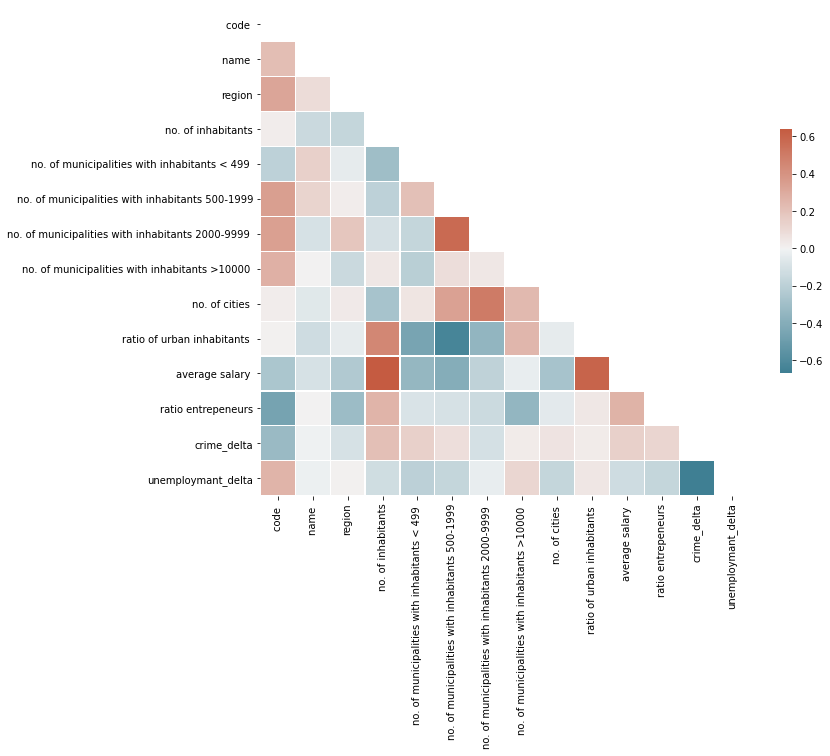

Correlations with label:


,loan_id,amount,duration,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,first_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash,credit_cash_mean,credit_cash_sum,credit_cash_max,credit_cash_std,credit_cash_min,col_another_bank,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest,interest_mean,interest_sum,interest_max,interest_std,interest_min,withd_cash,withd_cash_mean,withd_cash_sum,withd_cash_max,withd_cash_std,withd_cash_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_std,rem_another_bank_min,credit_card_withd,credit_card_withd_mean,credit_card_withd_sum,credit_card_withd_max,credit_card_withd_std,credit_card_withd_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,last_first_balance_ratio,last_max_balance_ratio,ratio_credit_cash,ratio_col_another_bank,ratio_withd_cash,ratio_rem_another_bank,ratio_credit_card_withd,ratio_interest,owner_count,disponent_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,crime_delta,unemploymant_delta,acc_age_on_loan,acc_age_mths,trans_mth,withdrawal_mth,credit_mth,avg_mth_income,salary_mth_calc,real_mth_income,ratio_real_salary_to_expected,ratio_withd_credit_mth,last_transaction_days,owner_age_on_loan,ratio_max_value_in_account_to_loan,ratio_last_value_in_account_to_loan,ratio_expected_income_to_payments,real_income_to_payments_ratio,log_credit_min,log_crime_delta,log_sanctions_std,log_col_another_bank_sum,log_col_another_bank_mean,log_ratio_max_value_in_acc_to_loan
status,0.121917,-0.128237,-0.003537,-0.168436,-0.007298,0.193985,0.019865,0.226679,-0.083467,0.138842,-0.020962,-0.097729,0.502993,0.126995,0.019421,0.004996,-0.087856,0.058619,0.024413,0.122053,0.110761,-0.005278,0.003361,-0.000019,0.203096,0.094239,0.025466,-0.0139,0.043572,0.064005,-0.084695,-0.069294,0.079072,0.314902,0.286268,-0.274294,-0.24354,-0.051181,-0.125393,-0.03891,-0.179912,-0.204384,-0.043192,0.137795,0.162357,0.158309,0.160894,0.153084,0.162646,0.003842,0.22164,0.101174,0.08506,-0.025943,0.177928,0.058313,0.008803,-0.044506,0.109771,0.02563,-0.005278,0.182415,-0.264412,-0.203213,-0.254507,0.025839,-0.257403,0.048169,-0.057676,-0.049027,-0.049331,0.044266,-0.057826,0.185935,0.091208,-0.217682,0.217682,0.012576,0.044261,0.104247,-0.204533,0.115595,0.036317,0.237998,0.043068,-0.145612,0.2199,0.2199,-0.022487,0.067839,0.038804,-0.057627,-0.007891,0.074296,0.035389,0.029973,0.040206,0.082499,-0.011979,0.013187,0.036389,0.083834,-0.088705,0.078792,0.078792,0.08225,0.055035,0.011567,-0.071685,0.185935,0.181182,0.019312,0.175691,-0.122921,-0.028047,0.126908,0.146587,0.105515,0.201175,0.129045,0.085067,-0.264577,0.135028,0.133555,0.149757


Result of feature selection:


['payments',
 'balance_mean',
 'balance_min',
 'reached_negative_balance',
 'unknown_sum',
 'sanctions_mean',
 'sanctions_sum',
 'sanctions_count',
 'sanctions_std',
 'credit_cash_max',
 'credit_cash_std',
 'col_another_bank_mean',
 'col_another_bank_sum',
 'col_another_bank_max',
 'col_another_bank_std',
 'col_another_bank_min',
 'interest_mean',
 'interest_min',
 'rem_another_bank',
 'rem_another_bank_mean',
 'rem_another_bank_sum',
 'rem_another_bank_max',
 'rem_another_bank_min',
 'mean_trans_profit',
 'credit_ratio',
 'withdrawal_ratio',
 'ratio_credit_cash',
 'ratio_rem_another_bank',
 'owner_count',
 'disponent_count',
 'salary_mth_calc',
 'real_mth_income',
 'ratio_withd_credit_mth',
 'real_income_to_payments_ratio',
 'log_sanctions_std']

Dataframe to output to file:


,loan_id,payments,balance_mean,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash_max,credit_cash_std,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest_mean,interest_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_min,mean_trans_profit,credit_ratio,withdrawal_ratio,ratio_credit_cash,ratio_rem_another_bank,owner_count,disponent_count,salary_mth_calc,real_mth_income,ratio_withd_credit_mth,real_income_to_payments_ratio,log_sanctions_std,status
0,5314,8033,12250.000000,1100.0,1.0,20100.0,0.0,0.0,0.0,0.0,9900.0,3774.806838,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,5025.000000,1.000000,0.000000,1.000000,0.000000,1,1,5025.000000,5025.000000,0.000000,0.625545,0.0,-1
1,5316,4610,52083.859459,700.0,1.0,62612.0,0.0,0.0,0.0,0.0,36574.0,13044.711945,0.000000,0.0,0.0,0.000000,0.0,168.540000,2.9,8.0,-2682.375000,-21459.0,-956.0,-4167.0,4638.918824,0.459459,0.540541,0.324324,0.216216,1,1,4638.918824,4291.668824,-0.656965,0.930948,0.0,1
2,6863,2118,30060.954167,800.0,1.0,27534.0,0.0,0.0,0.0,0.0,3700.0,2050.609665,13981.000000,69905.0,19065.0,2842.042399,12710.0,92.625000,48.6,3.0,-2824.333333,-8473.0,-66.0,-7936.0,-1087.266667,0.625000,0.375000,0.083333,0.125000,1,1,-1087.266667,-1748.600000,-1.217031,-0.825590,0.0,1
3,5325,2939,41297.480000,1000.0,1.0,47508.0,0.0,0.0,0.0,0.0,3900.0,2050.609665,19101.333333,114608.0,26448.0,3599.116929,17632.0,160.360000,132.8,2.0,-6994.000000,-13988.0,-6994.0,-6994.0,2086.500000,0.520000,0.480000,0.080000,0.080000,1,1,2086.500000,1503.666667,-0.774545,0.511625,0.0,1
4,7240,4579,57188.211111,600.0,1.0,40788.0,0.0,0.0,0.0,0.0,600.0,0.000000,45764.333333,274586.0,63366.0,8623.020391,42244.0,190.183333,77.1,3.0,-6584.666667,-19754.0,-756.0,-9499.0,4454.930769,0.481481,0.518519,0.037037,0.111111,1,1,4454.930769,4391.930769,-0.790415,0.959146,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,3242,44197.509884,200.0,1.0,101122.0,0.0,0.0,0.0,0.0,26388.0,6517.394689,0.000000,0.0,0.0,0.000000,0.0,145.472727,23.7,36.0,-1709.000000,-61524.0,-831.0,-2587.0,2618.124034,0.406977,0.593023,0.151163,0.209302,2,2,2618.124034,2402.540700,-0.594000,0.741067,0.0,1
324,5625,3703,55230.444068,800.0,1.0,56990.0,0.0,0.0,0.0,0.0,44352.0,13832.527973,0.000000,0.0,0.0,0.000000,0.0,223.050000,103.2,0.0,0.000000,0.0,0.0,0.0,3220.376498,0.474576,0.525424,0.271186,0.000000,1,1,3220.376498,3220.376498,-0.759988,0.869667,0.0,-1
325,6805,938,41994.907692,800.0,1.0,51200.0,0.0,0.0,0.0,0.0,31636.5,9517.351233,0.000000,0.0,0.0,0.000000,0.0,114.216667,41.0,6.0,-3387.500000,-20325.0,-2056.0,-4719.0,1570.498421,0.512821,0.487179,0.205128,0.153846,1,1,1570.498421,1177.248421,-0.816207,1.255062,0.0,1
326,7233,3217,56646.516129,1100.0,1.0,38211.0,0.0,0.0,0.0,0.0,49887.0,14644.196076,0.000000,0.0,0.0,0.000000,0.0,206.068421,51.1,0.0,0.000000,0.0,0.0,0.0,5562.846548,0.411290,0.588710,0.258065,0.000000,1,1,5562.846548,5562.846548,-0.663978,1.729203,0.0,1


Respective correlation matrix (triangle)


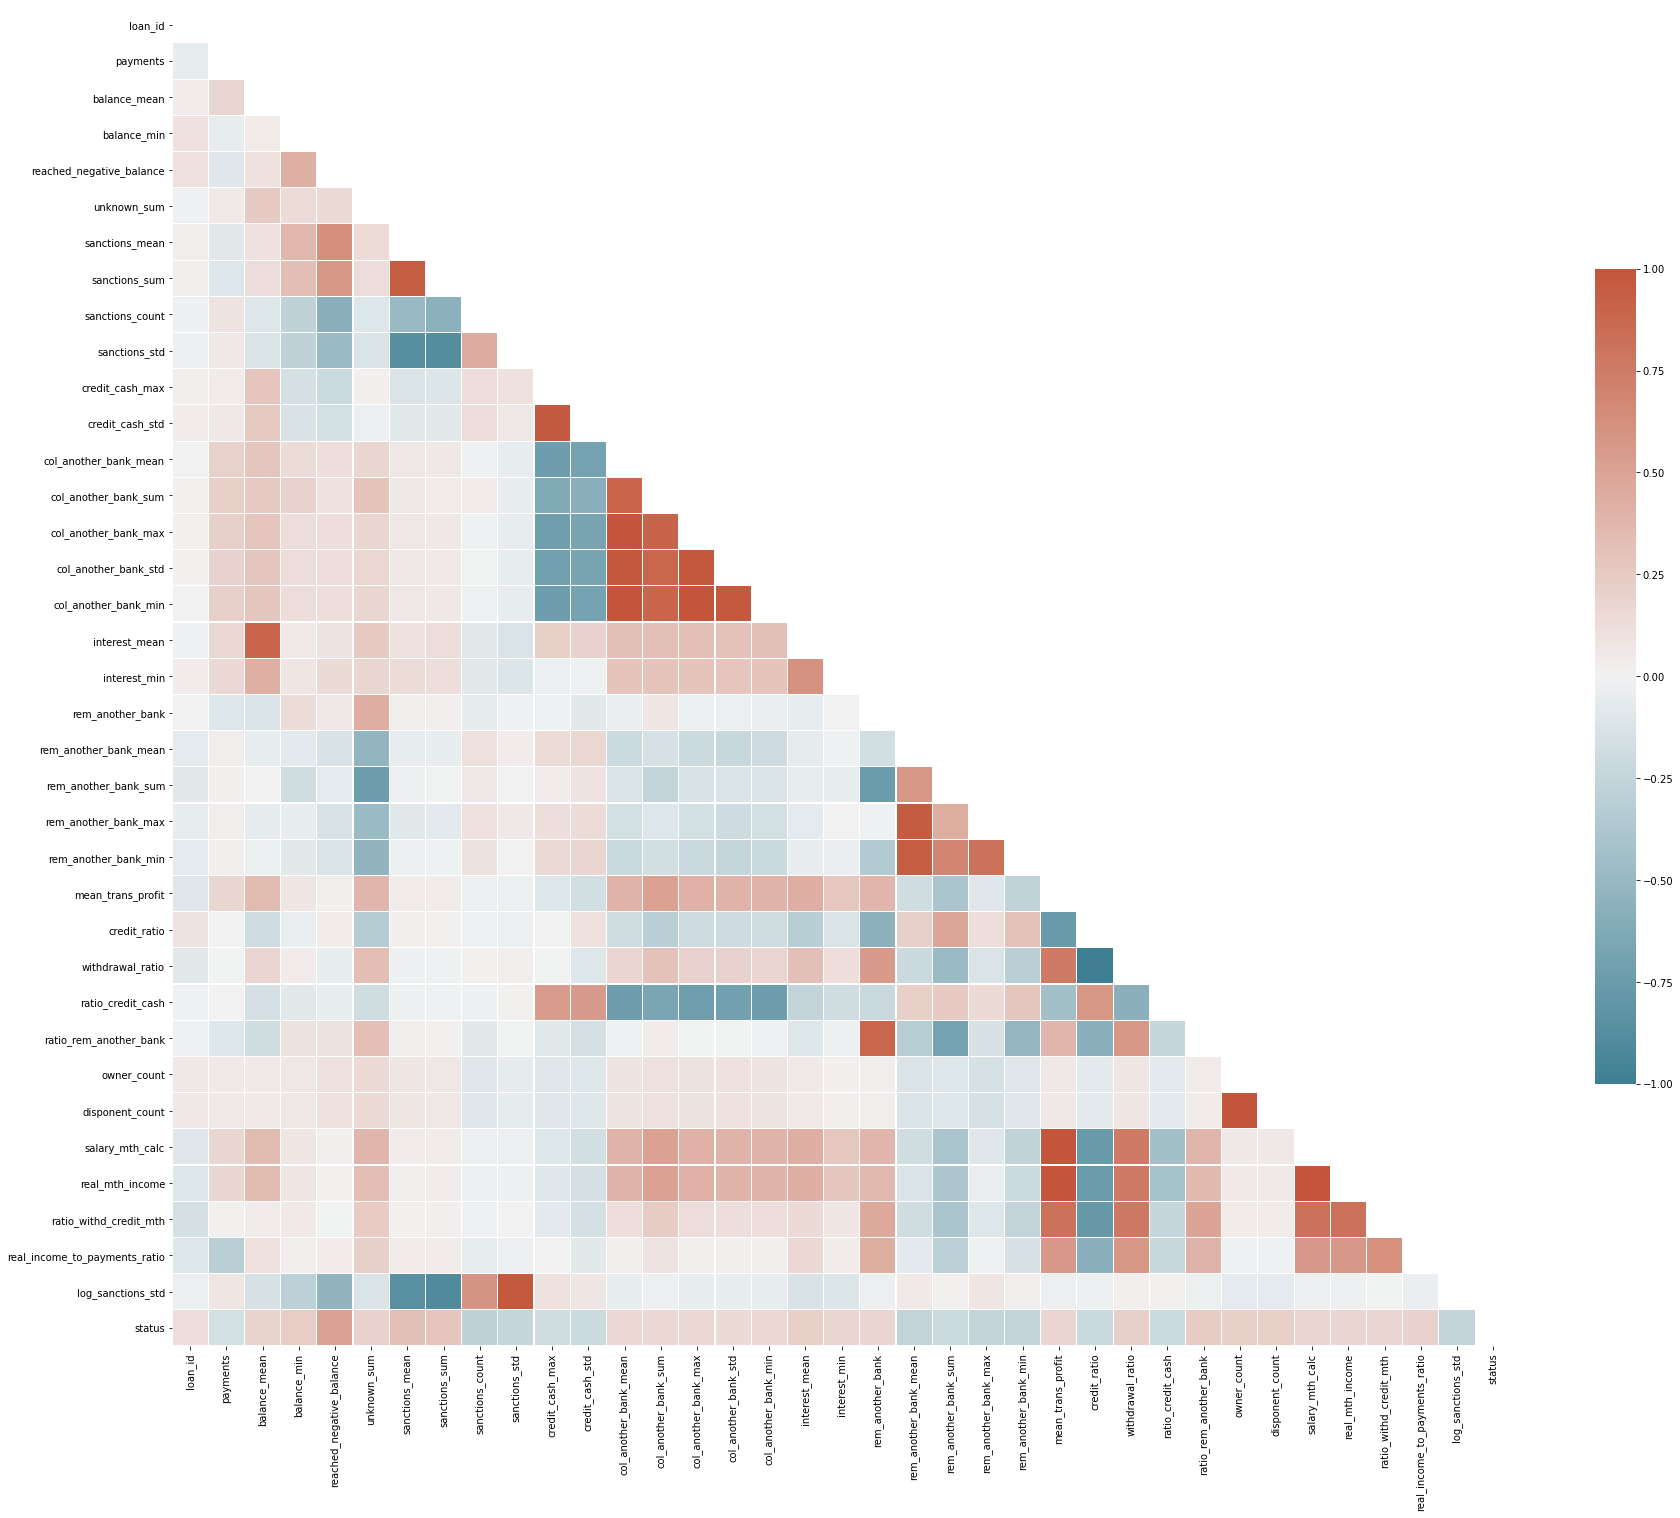

,loan_id,payments,balance_mean,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash_max,credit_cash_std,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest_mean,interest_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_min,mean_trans_profit,credit_ratio,withdrawal_ratio,ratio_credit_cash,ratio_rem_another_bank,owner_count,disponent_count,salary_mth_calc,real_mth_income,ratio_withd_credit_mth,real_income_to_payments_ratio,log_sanctions_std,status
0,5314,8033,12250.000000,1100.0,1.0,20100.0,0.0,0.0,0.0,0.0,9900.0,3774.806838,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,5025.000000,1.000000,0.000000,1.000000,0.000000,1,1,5025.000000,5025.000000,0.000000,0.625545,0.0,-1
1,5316,4610,52083.859459,700.0,1.0,62612.0,0.0,0.0,0.0,0.0,36574.0,13044.711945,0.000000,0.0,0.0,0.000000,0.0,168.540000,2.9,8.0,-2682.375000,-21459.0,-956.0,-4167.0,4638.918824,0.459459,0.540541,0.324324,0.216216,1,1,4638.918824,4291.668824,-0.656965,0.930948,0.0,1
2,6863,2118,30060.954167,800.0,1.0,27534.0,0.0,0.0,0.0,0.0,3700.0,2050.609665,13981.000000,69905.0,19065.0,2842.042399,12710.0,92.625000,48.6,3.0,-2824.333333,-8473.0,-66.0,-7936.0,-1087.266667,0.625000,0.375000,0.083333,0.125000,1,1,-1087.266667,-1748.600000,-1.217031,-0.825590,0.0,1
3,5325,2939,41297.480000,1000.0,1.0,47508.0,0.0,0.0,0.0,0.0,3900.0,2050.609665,19101.333333,114608.0,26448.0,3599.116929,17632.0,160.360000,132.8,2.0,-6994.000000,-13988.0,-6994.0,-6994.0,2086.500000,0.520000,0.480000,0.080000,0.080000,1,1,2086.500000,1503.666667,-0.774545,0.511625,0.0,1
4,7240,4579,57188.211111,600.0,1.0,40788.0,0.0,0.0,0.0,0.0,600.0,0.000000,45764.333333,274586.0,63366.0,8623.020391,42244.0,190.183333,77.1,3.0,-6584.666667,-19754.0,-756.0,-9499.0,4454.930769,0.481481,0.518519,0.037037,0.111111,1,1,4454.930769,4391.930769,-0.790415,0.959146,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,3242,44197.509884,200.0,1.0,101122.0,0.0,0.0,0.0,0.0,26388.0,6517.394689,0.000000,0.0,0.0,0.000000,0.0,145.472727,23.7,36.0,-1709.000000,-61524.0,-831.0,-2587.0,2618.124034,0.406977,0.593023,0.151163,0.209302,2,2,2618.124034,2402.540700,-0.594000,0.741067,0.0,1
324,5625,3703,55230.444068,800.0,1.0,56990.0,0.0,0.0,0.0,0.0,44352.0,13832.527973,0.000000,0.0,0.0,0.000000,0.0,223.050000,103.2,0.0,0.000000,0.0,0.0,0.0,3220.376498,0.474576,0.525424,0.271186,0.000000,1,1,3220.376498,3220.376498,-0.759988,0.869667,0.0,-1
325,6805,938,41994.907692,800.0,1.0,51200.0,0.0,0.0,0.0,0.0,31636.5,9517.351233,0.000000,0.0,0.0,0.000000,0.0,114.216667,41.0,6.0,-3387.500000,-20325.0,-2056.0,-4719.0,1570.498421,0.512821,0.487179,0.205128,0.153846,1,1,1570.498421,1177.248421,-0.816207,1.255062,0.0,1
326,7233,3217,56646.516129,1100.0,1.0,38211.0,0.0,0.0,0.0,0.0,49887.0,14644.196076,0.000000,0.0,0.0,0.000000,0.0,206.068421,51.1,0.0,0.000000,0.0,0.0,0.0,5562.846548,0.411290,0.588710,0.258065,0.000000,1,1,5562.846548,5562.846548,-0.663978,1.729203,0.0,1


In [22]:
def complete_dataset(loan_df, account_df, disp_df, card_df, client_df, trans_df, district_df):

    # Pre process all tables
    loan = process_loans(loan_df)
    account = process_account(account_df)
    trans = process_transactions(trans_df)
    disp = process_dispostition(disp_df)
    client = process_client(client_df)
    card = process_card(card_df)
    district = process_district(district_df)
    
    # Join tables
    main_df = loan.merge(account.rename(columns={'date': 'acc_create_date'}), on='account_id', how='left').merge(trans, on='account_id', how='left')
    main_df = main_df.drop(['district_id'], axis=1)    
    # display(main_df)

    df_disp_client_card = disp.merge(client, on='client_id', how='left').merge(card, on='disp_id', how='left')

    # display(df_disp_client_card)
    # missing_values(df_disp_client_card)
    
    # Drop card issue date (almost unique values)
    df_disp_client = df_disp_client_card.drop(['issued'], axis=1)
    df_disp_client = clean_numerical_missing_values(df_disp_client, -1)
    
    # print(df_disp_client.dtypes)
    # display(df_disp_client)

    # Now we aggreggate the remaining data
    df_disp_client = df_disp_client.sort_values(by=['account_id', 'type_O'], ascending=[True, False])\
                                   .groupby(['account_id'])\
                                   .agg({'type_O': ['count'],'type_U': ['count'],'gender': get_first,'birth_date': get_first,'district_id': get_first,'type': get_first}).reset_index()
    df_disp_client.columns= ['account_id', 'owner_count', 'disponent_count',
                             'owner_gender', 'owner_birthdate', 'district_id', 'card_type']
    df_disp_client['has_card'] = df_disp_client['card_type']
    df_disp_client.loc[df_disp_client["card_type"] > 0, "has_card"] = 1
    df_disp_client.loc[df_disp_client["card_type"] == 0, "has_card"] = -1
    # display(df_disp_client)
    
    # Final Join
    df = main_df.merge(df_disp_client.merge(district, on='district_id'), on='account_id')
    
    
    # 'Ratios' - resulting from operations that combine columns
    df['acc_age_on_loan']                        = (df['date']             - df['acc_create_date']).dt.days    
    df['acc_age_mths']                           = df['acc_age_on_loan']   / 30
    
    # (per month)
    df["trans_mth"]                              = df['total_ops']         / df["acc_age_mths"]
    df['withdrawal_mth']                         = df['withdrawal_mean']   / df["acc_age_mths"]
    df['credit_mth']                             = df['credit_mean']       / df["acc_age_mths"]
    df['avg_mth_income']                         =  (df['average salary '] + df['household'])               / 12
    df['salary_mth_calc']                        = df['credit_mean']       + df['withdrawal_mean']
    df['real_mth_income']                        =  df['salary_mth_calc']  + (df['household']               / 12)
    df.loc[df["pension"] > 0, "avg_mth_income"]  = (df["pension"]          + df['household'])               / 12
    df.loc[df["pension"] > 0, "real_mth_income"] = df["real_mth_income"]   + (df['pension']                 / 12)
    
    df['ratio_real_salary_to_expected']          = df['real_mth_income']   / df['avg_mth_income']
    df['ratio_withd_credit_mth']                 = df['withdrawal_mth']    / df['credit_mth']
    
    df['last_transaction_days']                  = (df['date']             - df['last_trans_date']).dt.days
    df['owner_age_on_loan']                      = (df['date']             - df['owner_birthdate']).dt.days / 365
    
    df["ratio_max_value_in_account_to_loan"]     = df["balance_max"]       / df["amount"]
    df["ratio_last_value_in_account_to_loan"]    = df["last_balance"]      / df["amount"]
    df['ratio_expected_income_to_payments']      = df['avg_mth_income']    / df['payments']
    df['real_income_to_payments_ratio']          = df['real_mth_income']   / df['payments']

    # log transformation applied to reduce skewness, approximating to a normal distribution
    df['log_credit_min']                         = df['credit_min'].transform(np.log1p)
    df['log_crime_delta']                        = df['crime_delta'].transform(np.log1p)
    df['log_sanctions_std']                      = df['sanctions_std'].transform(np.log1p)
    df['log_col_another_bank_sum']               = df['col_another_bank_sum'].transform(np.log1p)
    df['log_col_another_bank_mean']              = df['col_another_bank_mean'].transform(np.log1p)
    df['log_ratio_max_value_in_acc_to_loan']     = df['ratio_max_value_in_account_to_loan'].transform(np.log1p)

    
    # print('Age at time of loan (years)')
    # column_density_plot(df, 'owner_age_on_loan')
    
    df = df.drop(['district_id', 'account_id', 'owner_birthdate', 'pension', 'household', 'acc_create_date', 'last_trans_date'], axis=1)

    # display(df)

    # print('Features Histograms')
    # get_features_histogram(df, (25, 100))
        
    
    # status as last col
    df =  df[ [col for col in df if col not in ['status'] ] + ['status'] ]
    
    # Features selection
    select_features_filtering(df)
    #select_features_wrapper(df)
    
    print('Result of feature selection:')
    display(filter_features)
        
    df = df[['loan_id'] + filter_features + ['status']]
    #df = df[['loan_id'] + wrapper_features + ['status']]
    
    #df = df[['loan_id'] + ['amount','duration', 'payments', 'frequency', 'balance_mean', 'balance_max', 'balance_min', 'balance_std', 'last_balance', 'last_trans', 'reached_negative_balance', 'credit_mean', 'credit_count', 'credit_max', 'credit_min', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min', 'withdrawal_std', 'unknown_mean', 'unknown_sum', 'unknown_std', 'payment_statement_sum', 'payment_statement_count', 'ins_payment_mean', 'ins_payment_sum', 'ins_payment_count', 'sanctions_mean', 'sanctions_sum', 'sanctions_count', 'sanctions_std', 'credit_cash', 'credit_cash_mean', 'credit_cash_max', 'credit_cash_std', 'credit_cash_min', 'CAB', 'CAB_mean', 'CAB_min', 'interest', 'interest_mean', 'interest_sum', 'interest_max', 'interest_std', 'interest_min', 'withd_cash', 'withd_cash_mean', 'withd_cash_max', 'rem_another_bank', 'rem_another_bank_mean', 'rem_another_bank_sum', 'rem_another_bank_max', 'rem_another_bank_std', 'credit_card_withd', 'credit_card_withd_mean', 'credit_card_withd_sum', 'credit_card_withd_max', 'credit_card_withd_std', 'credit_card_withd_min', 'mean_trans_profit', 'total_ops', 'credit_ratio', 'withdrawal_ratio', 'last_max_balance_ratio', 'ratio_credit_cash', 'ratio_withd_cash', 'ratio_rem_another_bank', 'ratio_credit_card_withd', 'ratio_interest', 'owner_count', 'owner_gender', 'card_type', 'has_card', 'region', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ', 'ratio of urban inhabitants ', 'average salary ', 'ratio entrepeneurs', 'crime_delta', 'last_transaction_days', 'owner_age_on_loan', 'ratio_max_value_in_account_to_loan', 'acc_age_mths', 'withdrawal_per_mth', 'salary_mth_calc', 'avg_mth_income', 'real_mth_income', 'ratio_expected_income_to_payments', 'log_credit_min', 'log_sanctions_std', 'log_CAB_mean', 'log_ratio_max_value_in_acc_to_loan'] + ['status']]
    

    print('Dataframe to output to file:')
    display(df)
    print('Respective correlation matrix (triangle)')
    get_df_correlation(df, (30, 30))

    return df
        
        
dataset = complete_dataset(loan_df, account_df, disp_df, card_df, client_df, trans_df, district_df)
display(dataset)

In [23]:
def write_df_to_csv(df, dir_, filename):
    csv = df.to_csv(index = False)
    os.makedirs(dir_, exist_ok=True)
    path = "{}/{}".format(dir_, filename)

    with open(path, 'w') as fd: fd.write(csv)

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


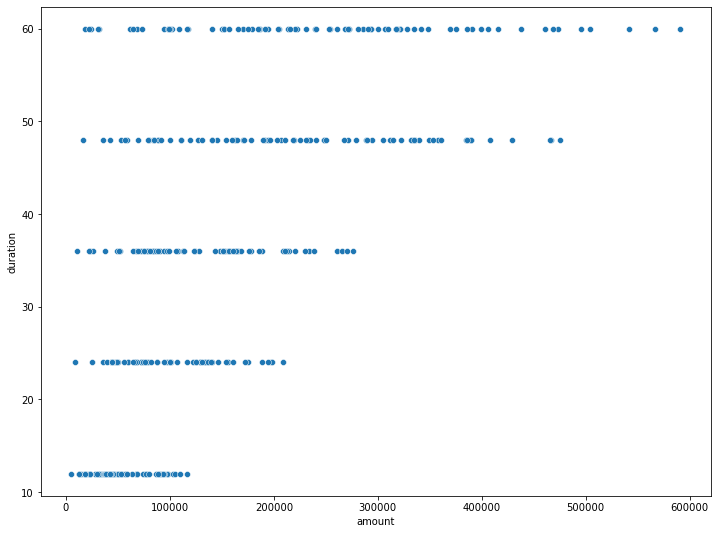

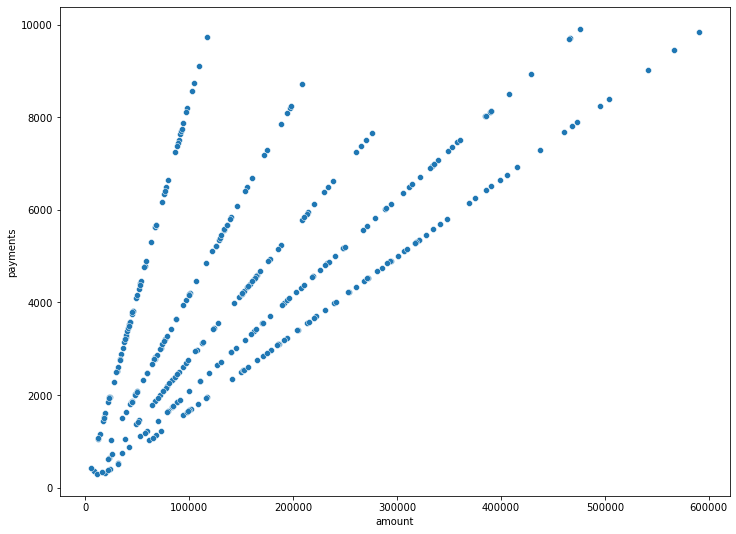

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


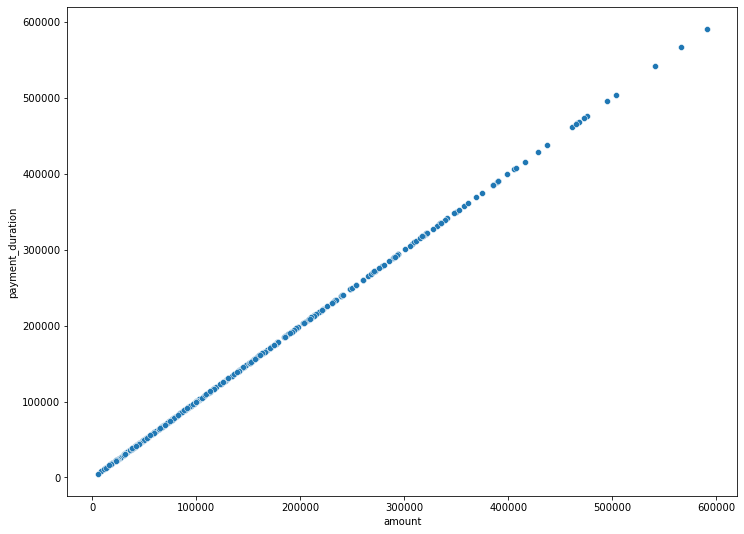

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan
Current processed_df


,trans_id,account_id,date,type,operation,amount,balance,k_symbol
395175,175,1,1996-12-31,withdrawal,withd_cash,-14.6,12659.9,payment for statement
396435,3530458,1,1996-12-31,credit,interest,59.2,12674.5,interest credited
388524,99,1,1996-12-18,withdrawal,withd_cash,-180.0,12615.3,
386550,25,1,1996-12-13,credit,col_another_bank,3679.0,16495.3,
386552,219,1,1996-12-13,withdrawal,withd_cash,-3700.0,12795.3,
...,...,...,...,...,...,...,...,...
202560,3459062,11382,1995-09-30,credit,interest,40.4,24272.4,interest credited
204824,3530267,11382,1995-09-30,credit,interest,37.0,24309.4,interest credited
200744,3431245,11382,1995-09-19,withdrawal,withd_cash,-6800.0,24232.0,
198263,3431070,11382,1995-09-10,credit,col_another_bank,30832.0,31032.0,


At end of process_transactions


,account_id,balance_mean,balance_max,balance_min,balance_std,last_balance,first_balance,last_trans_date,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,household,pension,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash,credit_cash_mean,credit_cash_sum,credit_cash_max,credit_cash_std,credit_cash_min,col_another_bank,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest,interest_mean,interest_sum,interest_max,interest_std,interest_min,withd_cash,withd_cash_mean,withd_cash_sum,withd_cash_max,withd_cash_std,withd_cash_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_std,rem_another_bank_min,credit_card_withd,credit_card_withd_mean,credit_card_withd_sum,credit_card_withd_max,credit_card_withd_std,credit_card_withd_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,last_first_balance_ratio,last_max_balance_ratio,ratio_credit_cash,ratio_col_another_bank,ratio_withd_cash,ratio_rem_another_bank,ratio_credit_card_withd,ratio_interest
0,1,17558.700000,30414.8,1000.0,4168.729384,12659.9,1000.0,1996-12-31,-14.6,1.0,1992.602000,50,12600.0,19.2,2298.080022,-1380.479365,63.0,-14.6,-7500.0,1463.225675,-2452.0,0.0,857.101695,50569.0,59,3136.099558,-14.6,-248.2,17.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,8,2600.000000,20800.0,12600.0,4120.679556,100.0,21.0,3679.000000,77259.0,3679.0,0.000000,3679.0,21.0,74.814286,1571.1,108.9,18.910798,19.2,47.0,-1015.706383,-47738.2,-14.6,1533.109438,-7500.0,16.0,-2452.000000,-39232.0,-2452.0,0.000000,-2452.0,0.0,0.0,0.0,0.0,0.000000,0.0,612.122635,113.0,0.442478,0.557522,29414.8,12.659900,0.416241,0.070796,0.185841,0.415929,0.141593,0.000000,0.185841
1,2,32590.624074,67529.6,1100.0,12061.705682,27840.6,1100.0,1993-12-31,-14.6,1.0,10394.786364,22,30354.0,13.5,11457.269613,-6276.393750,32.0,-14.6,-22400.0,6011.475327,-7266.0,0.0,1908.151515,62969.0,33,14927.239619,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2,2400.000000,4800.0,3700.0,1838.477631,1100.0,10.0,22259.600000,222596.0,30354.0,4266.123382,20236.0,10.0,128.930000,1289.3,203.0,49.413607,13.5,27.0,-6093.133333,-164514.6,-14.6,6547.076631,-22400.0,5.0,-7266.000000,-36330.0,-7266.0,0.000000,-7266.0,0.0,0.0,0.0,0.0,0.000000,0.0,4118.392614,54.0,0.407407,0.592593,66429.6,25.309636,0.412273,0.037037,0.185185,0.500000,0.092593,0.000000,0.185185
2,4,23648.623077,30623.5,800.0,5779.862046,24943.0,800.0,1996-12-31,-14.6,1.0,3348.264706,17,5553.0,66.6,2721.128176,-1453.527273,22.0,-14.6,-4100.0,1147.934693,-2078.0,5553.0,-1725.000000,-20700.0,12,1261.094402,-14.6,-87.6,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,800.000000,800.0,800.0,0.000000,800.0,10.0,5553.000000,55530.0,5553.0,0.000000,5553.0,6.0,98.416667,590.5,110.0,16.204866,66.6,11.0,-1261.600000,-13877.6,-14.6,1585.793139,-4100.0,11.0,-1645.454545,-18100.0,-1285.0,414.130744,-2078.0,0.0,0.0,0.0,0.0,0.000000,0.0,1894.737433,39.0,0.435897,0.564103,29823.5,31.178750,0.814505,0.025641,0.256410,0.282051,0.282051,0.000000,0.153846
3,6,30313.279839,40391.5,900.0,5582.676041,33509.2,900.0,1996-12-31,-14.6,1.0,3603.666667,51,6669.0,70.3,3285.410780,-2058.600000,73.0,-14.6,-11600.0,2064.857715,-3954.0,6669.0,-2075.000000,-58100.0,28,2252.625629,-14.6,-335.8,23.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1,900.000000,900.0,900.0,0.000000,900.0,27.0,6669.000000,180063.0,6669.0,0.000000,6669.0,23.0,122.782609,2824.0,146.3,17.056261,70.3,50.0,-1186.716000,-59335.8,-14.6,1950.114384,-11600.0,23.0,-3954.000000,-90942.0,-3954.0,0.000000,-3954.0,0.0,0.0,0.0,0.0,0.000000,0.0,1545.066667,124.0,0.411290,0.588710,39491.5,37.232444,0.829610,0.008065,0.217742,0.403226,0.185484

Corr matrix


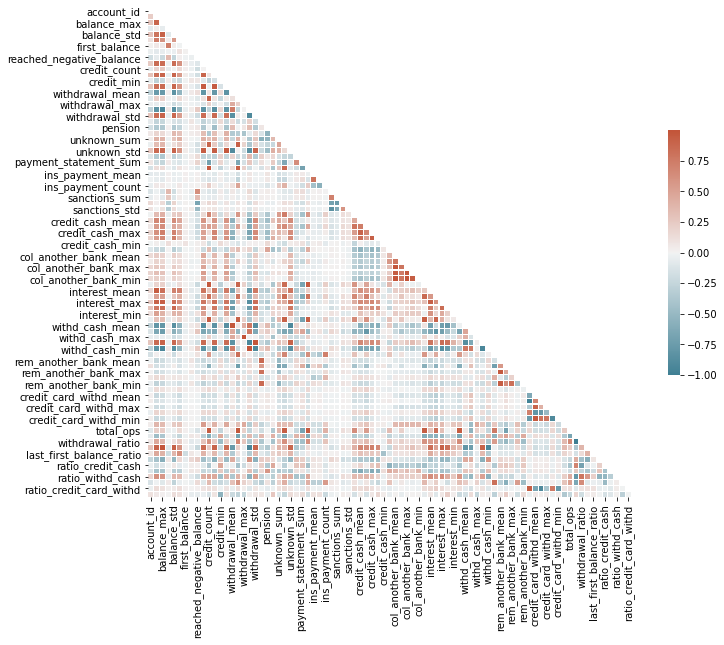

Transformed the categorical type column into numerical respective columns


,disp_id,client_id,account_id,type_O,type_U
0,1,1,1,1,0
1,2,2,2,1,0
2,3,3,2,0,1
3,4,4,3,1,0
4,5,5,3,0,1
...,...,...,...,...,...
5364,13647,13955,11349,1,0
5365,13648,13956,11349,0,1
5366,13660,13968,11359,1,0
5367,13663,13971,11362,1,0


2 categories are dependent. Therefore, remove one - removing redundancy


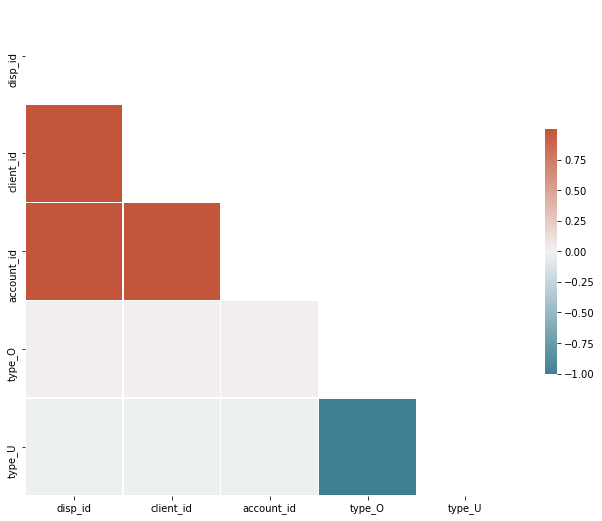

1 = female		 0 = male


,client_id,district_id,gender,birth_date
0,1,18,1,1970-12-13
1,2,1,0,1945-02-04
2,3,1,1,1940-10-09
3,4,5,0,1956-12-01
4,5,5,1,1960-07-03
...,...,...,...,...
5364,13955,1,1,1945-10-30
5365,13956,1,0,1943-04-06
5366,13968,61,0,1968-04-13
5367,13971,67,1,1962-10-19


code                                                 0.0
name                                                 0.0
region                                               0.0
no. of inhabitants                                   0.0
no. of municipalities with inhabitants < 499         0.0
no. of municipalities with inhabitants 500-1999      0.0
no. of municipalities with inhabitants 2000-9999     0.0
no. of municipalities with inhabitants >10000        0.0
no. of cities                                        0.0
ratio of urban inhabitants                           0.0
average salary                                       0.0
unemploymant rate '95                                0.0
unemploymant rate '96                                0.0
no. of enterpreneurs per 1000 inhabitants            0.0
no. of commited crimes '95                           0.0
no. of commited crimes '96                           0.0
dtype: float64

District Features Financial Relation


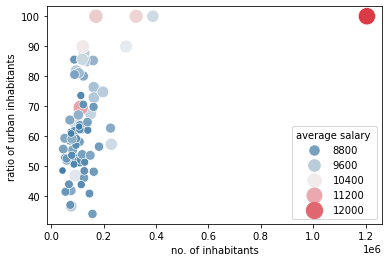

The final district plot, with additional features and having converted some features to ratios:


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,crime_delta,unemploymant_delta
0,1,17,0,1204953,0,0,0,1,1,1.000,12541,0.167,0.011146,0.14
1,2,0,1,88884,80,26,6,2,5,0.467,8507,0.132,0.005794,0.18
2,3,1,1,75232,55,26,4,1,5,0.417,8980,0.111,-0.000146,0.26
3,4,27,1,149893,63,29,6,2,6,0.674,9753,0.109,0.004323,0.41
4,5,29,1,95616,65,30,4,1,6,0.514,9307,0.118,0.004434,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,42,4,182027,17,49,12,2,7,0.564,8746,0.090,0.000429,0.41
73,74,43,4,323870,0,0,0,1,1,1.000,10673,0.100,-0.001343,0.69
74,75,53,4,138032,67,30,4,2,5,0.646,8819,0.099,0.003202,0.28
75,76,62,4,127369,31,32,13,2,7,0.512,8369,0.107,-0.007294,1.15


And the corresponding correlation matrix:


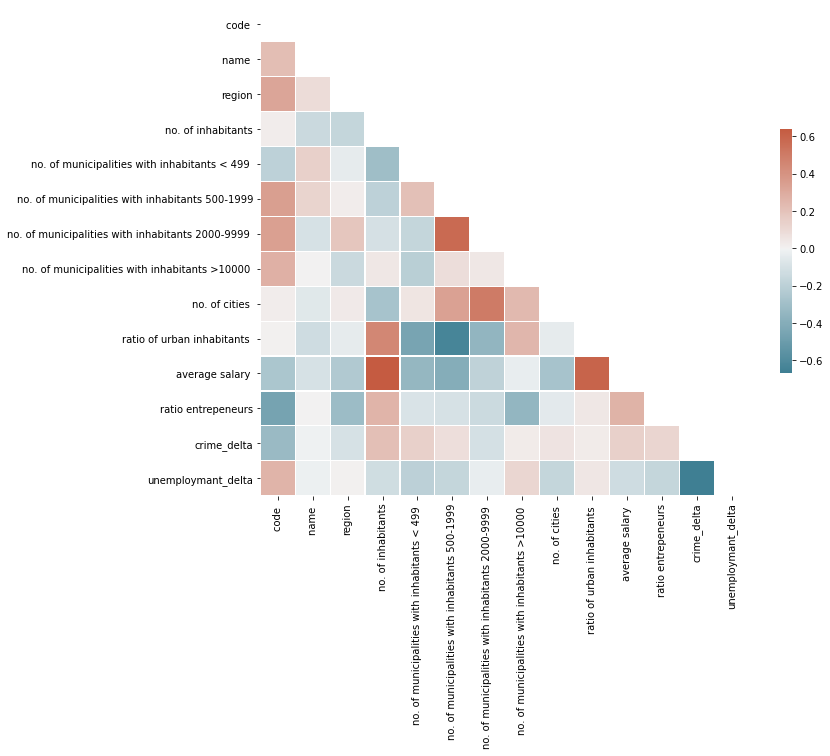

Correlations with label:


,loan_id,amount,duration,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,first_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash,credit_cash_mean,credit_cash_sum,credit_cash_max,credit_cash_std,credit_cash_min,col_another_bank,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest,interest_mean,interest_sum,interest_max,interest_std,interest_min,withd_cash,withd_cash_mean,withd_cash_sum,withd_cash_max,withd_cash_std,withd_cash_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_std,rem_another_bank_min,credit_card_withd,credit_card_withd_mean,credit_card_withd_sum,credit_card_withd_max,credit_card_withd_std,credit_card_withd_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,last_first_balance_ratio,last_max_balance_ratio,ratio_credit_cash,ratio_col_another_bank,ratio_withd_cash,ratio_rem_another_bank,ratio_credit_card_withd,ratio_interest,owner_count,disponent_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,crime_delta,unemploymant_delta,acc_age_on_loan,acc_age_mths,trans_mth,withdrawal_mth,credit_mth,avg_mth_income,salary_mth_calc,real_mth_income,ratio_real_salary_to_expected,ratio_withd_credit_mth,last_transaction_days,owner_age_on_loan,ratio_max_value_in_account_to_loan,ratio_last_value_in_account_to_loan,ratio_expected_income_to_payments,real_income_to_payments_ratio,log_credit_min,log_crime_delta,log_sanctions_std,log_col_another_bank_sum,log_col_another_bank_mean,log_ratio_max_value_in_acc_to_loan
status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Result of feature selection:


['payments',
 'balance_mean',
 'balance_min',
 'reached_negative_balance',
 'unknown_sum',
 'sanctions_mean',
 'sanctions_sum',
 'sanctions_count',
 'sanctions_std',
 'credit_cash_max',
 'credit_cash_std',
 'col_another_bank_mean',
 'col_another_bank_sum',
 'col_another_bank_max',
 'col_another_bank_std',
 'col_another_bank_min',
 'interest_mean',
 'interest_min',
 'rem_another_bank',
 'rem_another_bank_mean',
 'rem_another_bank_sum',
 'rem_another_bank_max',
 'rem_another_bank_min',
 'mean_trans_profit',
 'credit_ratio',
 'withdrawal_ratio',
 'ratio_credit_cash',
 'ratio_rem_another_bank',
 'owner_count',
 'disponent_count',
 'salary_mth_calc',
 'real_mth_income',
 'ratio_withd_credit_mth',
 'real_income_to_payments_ratio',
 'log_sanctions_std']

Dataframe to output to file:


,loan_id,payments,balance_mean,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,credit_cash_max,credit_cash_std,col_another_bank_mean,col_another_bank_sum,col_another_bank_max,col_another_bank_std,col_another_bank_min,interest_mean,interest_min,rem_another_bank,rem_another_bank_mean,rem_another_bank_sum,rem_another_bank_max,rem_another_bank_min,mean_trans_profit,credit_ratio,withdrawal_ratio,ratio_credit_cash,ratio_rem_another_bank,owner_count,disponent_count,salary_mth_calc,real_mth_income,ratio_withd_credit_mth,real_income_to_payments_ratio,log_sanctions_std,status
0,5895,1566,54520.202247,800.0,1.0,96257.5,0.0,0.0,0.0,0.0,36637.5,10232.429013,0.000000,0.0,0.0,0.000000,0.0,227.792857,82.2,19.0,-4473.789474,-85002.0,-3525.0,-5528.0,7116.203051,0.337079,0.662921,0.179775,0.213483,1,1,7116.203051,6655.536384,-0.442707,4.250023,0.0,NaN
1,7122,7240,31518.182051,-718.6,-1.0,37433.0,-4.6,-4.6,1.0,0.0,41871.0,15361.777209,0.000000,0.0,0.0,0.000000,0.0,145.026667,15.5,23.0,-3067.347826,-70549.0,-331.0,-6395.0,4124.511189,0.371795,0.628205,0.179487,0.294872,1,1,4124.511189,3764.094523,-0.567061,0.519903,0.0,NaN
2,6173,4845,40175.612500,200.0,1.0,91074.0,0.0,0.0,0.0,0.0,9700.0,4750.087718,31977.000000,639540.0,43605.0,5965.038139,29070.0,178.345000,45.7,61.0,-1213.147541,-74002.0,-281.0,-2692.0,10699.080031,0.244318,0.755682,0.017045,0.346591,1,1,10699.080031,10474.746698,-0.300827,2.161970,0.0,NaN
3,6142,3698,44440.912676,1000.0,1.0,41500.0,0.0,0.0,0.0,0.0,1200.0,141.421356,24405.600000,244056.0,33280.0,4677.219478,22187.0,166.055556,54.2,24.0,-885.500000,-21252.0,-2.0,-2872.0,7620.902857,0.295775,0.704225,0.028169,0.338028,2,2,7620.902857,7593.986190,-0.354032,2.053539,0.0,NaN
4,5358,3210,20231.313158,900.0,1.0,62488.0,0.0,0.0,0.0,0.0,8800.0,2049.690583,0.000000,0.0,0.0,0.000000,0.0,82.389474,19.8,16.0,-3115.000000,-49840.0,-3115.0,-3115.0,667.010794,0.456140,0.543860,0.289474,0.140351,1,1,667.010794,407.427461,-0.756212,0.126924,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,4989,7348,30797.487500,800.0,1.0,27714.0,0.0,0.0,0.0,0.0,49101.0,16398.898095,0.000000,0.0,0.0,0.000000,0.0,170.906667,38.0,0.0,0.000000,0.0,0.0,0.0,465.253384,0.517857,0.482143,0.250000,0.000000,1,1,465.253384,465.253384,-0.947171,0.063317,0.0,NaN
350,5221,4376,59684.298851,1000.0,1.0,38216.0,0.0,0.0,0.0,0.0,49972.0,15021.046698,0.000000,0.0,0.0,0.000000,0.0,229.215385,10.9,0.0,0.000000,0.0,0.0,0.0,4168.815467,0.436782,0.563218,0.287356,0.000000,1,1,4168.815467,4168.815467,-0.719077,0.952654,0.0,NaN
351,6402,5812,46755.305769,1100.0,1.0,44826.0,0.0,0.0,0.0,0.0,14300.0,7400.900846,37775.833333,679965.0,52305.0,6686.017290,34870.0,197.255556,87.3,0.0,0.000000,0.0,0.0,0.0,7925.646154,0.375000,0.625000,0.028846,0.000000,1,1,7925.646154,7925.646154,-0.558942,1.363669,0.0,NaN
352,5346,2318,29645.320175,500.0,1.0,36142.0,0.0,0.0,0.0,0.0,15600.0,5441.228196,14898.285714,312864.0,20858.0,2493.127356,13905.0,121.690476,36.8,0.0,0.000000,0.0,0.0,0.0,2191.168125,0.438596,0.561404,0.070175,0.000000,1,1,2191.168125,2191.168125,-0.698618,0.945284,0.0,NaN


Respective correlation matrix (triangle)


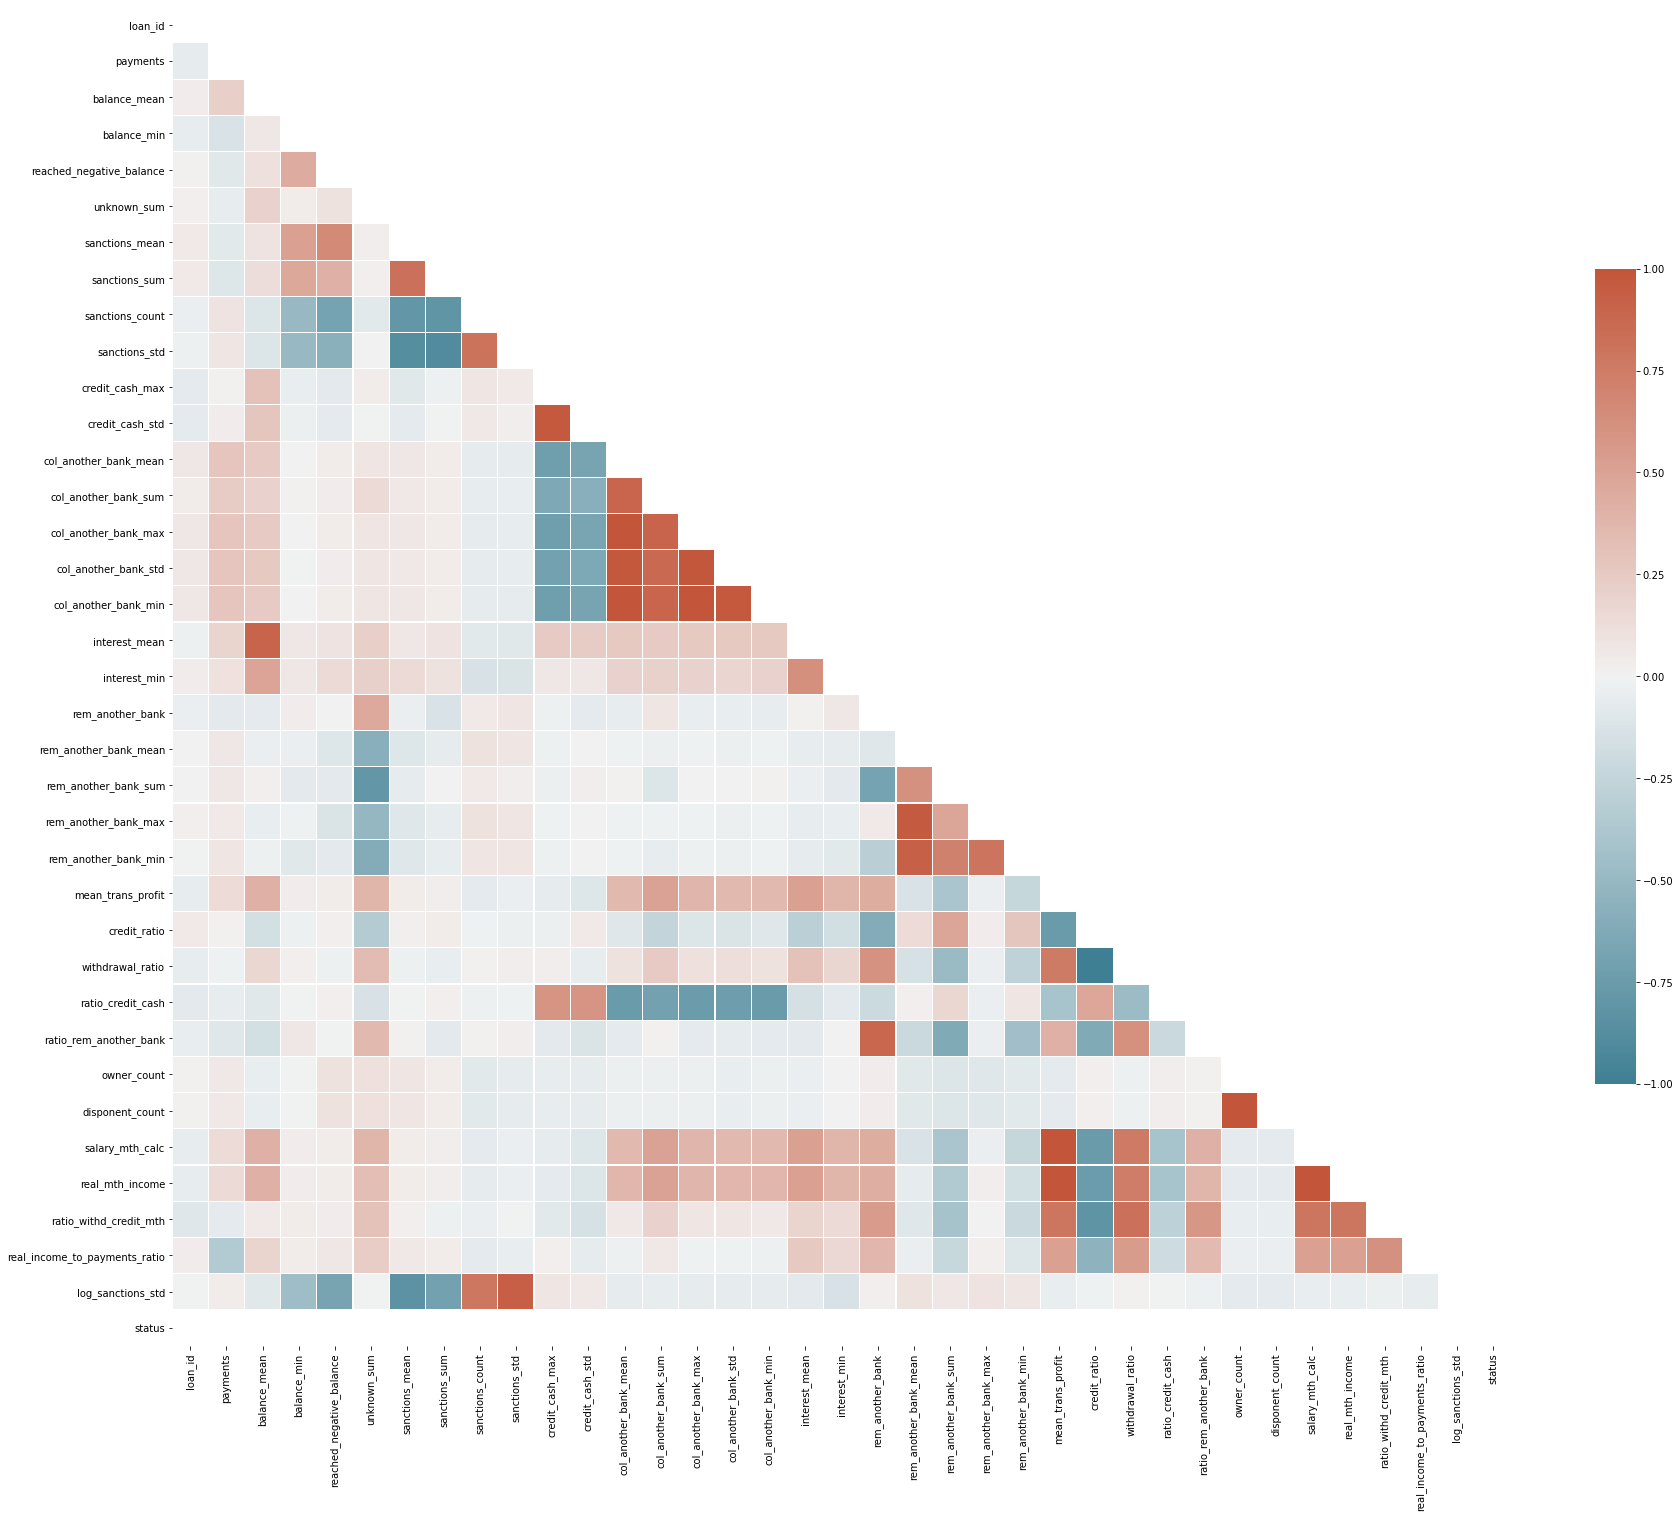

In [25]:

#dataset = process_transactions(trans_df, True)
#write_df_to_csv(dataset, 'dataset', 'preprocessed_transactions.csv')

# Outputting the resultant table to a final csv
write_df_to_csv(dataset, 'dataset', 'preprocessed_data_3.csv')

test_dataset = complete_dataset(loan_test_df, account_df, disp_df, card_test_df, client_df, trans_test_df, district_df)
write_df_to_csv(test_dataset, 'dataset', 'test_dataset_3.csv')